# Introduction
The following program was authored by Max Tejera in 2023-2024. The program was written to conduct analysis on the impacts of the Colorado Equal Pay for Equal Work Act (EPEWA) on the gender wage gap in Colorado. The original analysis was for Max's master of economics capstone research project at the University of Colorado Denver during the fall term of 2023. The code was originally authored in Stata, but has been translated to Python here with some additional functionality.

# Section 0: Setup
These two blocks install / import libraries that will be used in the project.

In [1]:
pip install ipumspy pandas beautifulsoup4 lxml statsmodels plotly tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import ipumspy as ipums
import gzip
import shutil
import requests
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.graph_objects as go
import warnings
import re
from ipumspy import IpumsApiClient, CpsExtract, readers, ddi
from bs4 import BeautifulSoup
from pathlib import Path
from ipumspy import readers
from bs4 import BeautifulSoup
from tabulate import tabulate

# Section 1: Load Current Population Survey Data via API
This section uses the IPUMSPY library from IPUMS and an API key saved to a local disk folder to load the selected sample from the Current Population Survey (CPS) into a Pandas dataframe.

The selected sample is every month of the survey since January 2010. Later on the sample will be divided into the two time periods by the EPEWA variable (Equal Pay for Equal Work Act). EPEWA was passed during the Colorado 2019 legislative session and came into effect January 2021. To create a before and after comparison, the pre-law period was defined as January 2010 to December 2020. This period was chosen because the U.S. economy was mostly stable during this time, with some major abberations in the latter 10 months of 2020. This pre-law period is intended to capture a pre-trend in the gender wage gap prior to EPEWA coming into effect. The larger sample of 2010-2019 period likely offsets any major disruptions from the pandemic.

The CPS variables selected are elaborated on in the later sections. The number of variables selected has been minimized to optimize loading time. Loading the data into the Pandas can take a long time. As of this writing, the loading step takes approximately 30 minutes. I believe this is due to how IPUMSPY maps the data while loading.

The sample names were pulled from __[IPUMS](https://cps.ipums.org/cps-action/samples/sample_ids)__. There is room to improve this code by webscraping the sample names, which the webpage is set up to do so conveniently.

IPUMS requires all researchers to cite them when using their data. They are cited below and within the code.

##### Citation
> Sarah Flood, Miriam King, Renae Rodgers, Steven Ruggles, J. Robert Warren, Daniel Backman, Annie Chen, Grace Cooper, Stephanie Richards, Megan Schouweiler, and Michael Westberry. IPUMS CPS: Version 11.0 [dataset]. Minneapolis, MN: IPUMS, 2023. https://doi.org/10.18128/D030.V11.0

##### To Do:
> 1. Optimize Loading Code For Faster Processing
> 2. Webscrape Sample Names

In [3]:
# Open IPUMS API

api_key_file_path = r"C:\EconThesis\EqualPayForEqualWork\IPUMSAPIKEY03212024.txt"
with open(api_key_file_path, "r") as file:
    api_key = file.read().strip()

ipums = IpumsApiClient(api_key)

In [4]:
# Define sample of the Current Population Survey to extract from IPUMS.
# The CPS Samples come from here:
# https://cps.ipums.org/cps-action/samples/sample_ids

CpsSamples = [
'cps2010_01s',	'cps2010_02b',	'cps2010_03b',	'cps2010_04b',	'cps2010_05s',	'cps2010_06s',	'cps2010_07s',	'cps2010_08s',	'cps2010_09s',	'cps2010_10s',	'cps2010_11s',	'cps2010_12s',
'cps2011_01s',	'cps2011_02b',	'cps2011_03b',	'cps2011_04b',	'cps2011_05s',	'cps2011_06s',	'cps2011_07s',	'cps2011_08s',	'cps2011_09s',	'cps2011_10s',	'cps2011_11s',	'cps2011_12s',
'cps2012_01s',	'cps2012_02b',	'cps2012_03b',	'cps2012_04b',	'cps2012_05s',	'cps2012_06s',	'cps2012_07s',	'cps2012_08s',	'cps2012_09s',	'cps2012_10s',	'cps2012_11s',	'cps2012_12s',
'cps2013_01b',	'cps2013_02s',	'cps2013_03b',	'cps2013_04b',	'cps2013_05b',	'cps2013_06s',	'cps2013_07s',	'cps2013_08s',	'cps2013_09s',	'cps2013_10s',	'cps2013_11s',	'cps2013_12s',
'cps2014_01s',	'cps2014_02s',	'cps2014_03b',	'cps2014_04b',	'cps2014_05b',	'cps2014_06s',	'cps2014_07s',	'cps2014_08s',	'cps2014_09s',	'cps2014_10s',	'cps2014_11s',	'cps2014_12s',
'cps2015_01s',	'cps2015_02s',	'cps2015_03b',	'cps2015_04b',	'cps2015_05s',	'cps2015_06s',	'cps2015_07s',	'cps2015_08s',	'cps2015_09s',	'cps2015_10s',	'cps2015_11b',	'cps2015_12s',
'cps2016_01s',	'cps2016_02s',	'cps2016_03b',	'cps2016_04b',	'cps2016_05b',	'cps2016_06s',	'cps2016_07b',	'cps2016_08s',	'cps2016_09s',	'cps2016_10s',	'cps2016_11s',	'cps2016_12s',
'cps2017_01b',	'cps2017_02s',	'cps2017_03b',	'cps2017_04b',	'cps2017_05s',	'cps2017_06s',	'cps2017_07s',	'cps2017_08s',	'cps2017_09s',	'cps2017_10s',	'cps2017_11s',	'cps2017_12s',
'cps2018_01s',	'cps2018_02s',	'cps2018_03b',	'cps2018_04b',	'cps2018_05s',	'cps2018_06s',	'cps2018_07s',	'cps2018_08s',	'cps2018_09s',	'cps2018_10s',	'cps2018_11s',	'cps2018_12s',
'cps2019_01s',	'cps2019_02s',	'cps2019_03b',	'cps2019_04b',	'cps2019_05s',	'cps2019_06s',	'cps2019_07s',	'cps2019_08s',	'cps2019_09s',	'cps2019_10s',	'cps2019_11s',	'cps2019_12s',
'cps2020_01s',	'cps2020_02s',	'cps2020_03b',	'cps2020_04b',	'cps2020_05b',	'cps2020_06s',	'cps2020_07b',	'cps2020_08s',	'cps2020_09b',	'cps2020_10s',	'cps2020_11s',	'cps2020_12s',
'cps2021_01b',	'cps2021_02s',	'cps2021_03b',	'cps2021_04b',	'cps2021_05b',	'cps2021_06s',	'cps2021_07s',	'cps2021_08s',	'cps2021_09s',	'cps2021_10s',	'cps2021_11s',	'cps2021_12s',
'cps2022_01s',	'cps2022_02s',	'cps2022_03b',	'cps2022_04s',	'cps2022_05s',	'cps2022_06s',	'cps2022_07s',	'cps2022_08s',	'cps2022_09s',	'cps2022_10s',	'cps2022_11s',	'cps2022_12s',
'cps2023_01s',	'cps2023_02s',	'cps2023_03b',	'cps2023_04b',	'cps2023_05b',	'cps2023_06s',	'cps2023_07s',	'cps2023_08s',	'cps2023_09s',	'cps2023_10s',	'cps2023_11s',	'cps2023_12s',
'cps2024_01s',	'cps2024_02b',	'cps2024_03b',								
]

CpsVariables = [
    "YEAR", 
    "MONTH", 
    "MISH",
    "STATEFIP", 
    "METFIPS", 
    "EARNWEEK2", 
    "AGE", 
    "SEX", 
    "RACE", 
    "HISPAN", 
    "IND", 
    "CLASSWKR",
    "WKSTAT", 
    "EDUC",
]

extract = CpsExtract(samples=CpsSamples, variables=CpsVariables, collection='cps')

print('Sarah Flood, Miriam King, Renae Rodgers, Steven Ruggles, J. Robert Warren, Daniel Backman, Annie Chen, Grace Cooper, Stephanie Richards, Megan Schouweiler, and Michael Westberry. IPUMS CPS: Version 11.0 [dataset]. Minneapolis, MN: IPUMS, 2023. https://doi.org/10.18128/D030.V11.0')

Sarah Flood, Miriam King, Renae Rodgers, Steven Ruggles, J. Robert Warren, Daniel Backman, Annie Chen, Grace Cooper, Stephanie Richards, Megan Schouweiler, and Michael Westberry. IPUMS CPS: Version 11.0 [dataset]. Minneapolis, MN: IPUMS, 2023. https://doi.org/10.18128/D030.V11.0


In [5]:
# Submit the extract request using the client object

extract_id = ipums.submit_extract(extract)
print(extract_id)

In [6]:
# Confirm IPUMS extract has been started or finished

extract_status = ipums.extract_status(extract)
print(extract_status)

started


In [7]:
# Wait for the extract to finish

ipums.wait_for_extract(extract)

In [8]:
# Define where the extract will be downloaded

download_dir = Path(r"C:\EconThesis\EqualPayForEqualWork")
ipums.download_extract(extract_id, download_dir=download_dir)
print(f"Extract downloaded to: {download_dir}")

Extract downloaded to: C:\EconThesis\EqualPayForEqualWork


In [9]:
# Reference the most recently downloaded files

xml_files = sorted(download_dir.glob("*.xml"), key=lambda f: f.stat().st_mtime)
dat_gz_files = sorted(download_dir.glob("*.dat.gz"), key=lambda f: f.stat().st_mtime)
ddi_file = xml_files[-1]
dat_gz_file = dat_gz_files[-1]

# Read the DDI file, which maps the raw data

ddi = readers.read_ipums_ddi(ddi_file)

# Get the correct .dat file name from the DDI

dat_file = download_dir / ddi.file_description.filename

if not dat_file.name.endswith('.dat'):
    dat_file = dat_file.with_suffix('.dat')

if not dat_file.exists():
    with gzip.open(dat_gz_file, 'rb') as f_in:
        with open(dat_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Decompressed data file saved to: {dat_file}")

# The next step uses the DDI file and the .dat data file to read the IPUMS data into Pandas for later manipulation.

C:\Users\tejer\anaconda3\lib\site-packages\ipumspy\readers.py:49: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.
  warnings.warn(


Decompressed data file saved to: C:\EconThesis\EqualPayForEqualWork\cps_00036.dat


The dataset is large and must be organized with the DDI file.
The next step breaks the database into small chunks and applies filters to the data to make this task faster.
The step still runs slowly - about 30 minutes. To speed this process up, the dataset is pre-filtered as it is loaded. The original dataset had approximately 8 million observations. The dataset ultimately used for analysis will have approximately half a million observations. Given so many are dropped, below is an explanation for the exclusions:

1. The CPS interviews respondents for four months, takes an eight month break, then interviews them again for four months. The CPS does this in rotation. Therefore, only one eigth of the data in the CPS represents a unique respondent. MISH==8 selects the last month of interviews for a given respondent. This is the last month in which the respondent is asked about their weekly earnings, the primary variable of interest.
2. To allow for a more direct comparison of male and female workers, only full-time workers (35+ hours / week) were considered. These are coded as WKSTAT==11.
3. Similarly, to allow for a more direct comparison of workers only 'Prime Working Age' workers are considered. This is to exclude workers that may have high variation due to school schedules (less than age 24) or may be experiencing wage penalties for approaching retirement (greater than 55).
4. EARNWEEK2 is the endogenous variable of interest. It is what the respondent reported earning from employment before taxes during the week of the 12th in the prior month. Starting in 2023, the CPS began rounding these values to preserve privacy of higher earning respondents. Any respondents making above 150,000 per year were rounded or topcoded to preserve privacy. This removes any variation above this income level and warrants excluding those observations in which EARNWEEK2 is the equivalent of 150,000 per year or more. This likely means all measures of the gender wage gap considered in the analysis are lower than in the population, as men tend to be more represented in higher income and leadership roles.
5. Respondents reporting that they make less than the federal minimum wage equivalent (40 hours x 7.25 per hour = 290) were excluded to ensure respondents' answers are consistent with working full time with the more conventional 40 hour work week. Because respondents describe full time has 35+ hours a week, this potentially excludes workers making up to 8.29 per hour but only working 35 hours per week. These workers are unlikely to be affected significantly by EPEWA, so this is considered an acceptable exclusion.

The combination of (4) and (5) above result in the data considering approximately the middle 60% of the U.S. income distribution, with a slight skew to higher earners.

In [10]:
iter_microdata = readers.read_microdata_chunked(ddi, dat_file, chunksize=3000000)

# Apply all filters within the list comprehension

ipums_df_list = [ chunk[ 
    
    (chunk["MISH"] == 8) & 
    (chunk["WKSTAT"] == 11) & 
    (chunk["AGE"] >= 24) & 
    (chunk["AGE"] <= 55) & 
    (chunk["EARNWEEK2"] < 2884.61) & 
    (chunk["EARNWEEK2"] > 290) ] 

for chunk in iter_microdata ]

# Some explanation for these filters:
# MISH=8 are the relevant samples where a unique EARNWEEK variable exists for each person in the sample.
# WKSTAT <= 11 are full time workers.
# The AGE specifications are for prime working age workers.
# The EARNWEEK2 specifications omits people reporting more than $150,000 per year and less than minimum wage.
# This last exclusion is to address topcoding.
# In most cases, CPS does not release specific earnings information for those making above $150,000 per year.

# Concatenate the filtered chunks into one DataFrame
ipums_df = pd.concat(ipums_df_list, ignore_index=True)

In [11]:
# Check the size of the original data extraction
print(len(ipums_df))

563269


In [12]:
# Set display options for future results. This swaps scientific notation for 4 decimal places.

pd.set_option('display.float_format', '{:.4f}'.format)

# Section 2: Minimum Wage Webscrape and Exclusion

The following section scrapes the __[historical](https://www.dol.gov/agencies/whd/state/minimum-wage/history)__ historical and __[current](https://www.dol.gov/agencies/whd/mw-consolidated)__ state minimum wages by state from two webpages hosted by the US DOL, then uses this information to exclude from the sample workers who reported making less than a state's full time minimum wage weekly earnings in a given state in a given year. This exclusion is intended to address omitted variable bias of minimum wage increases reducing the gender wage gap. Because women earn less than men, it is likely that women are more likely to work minimum wage than men and benefit more from minimum wage increases than men. 

This effect can differ significantly by state. In California, the minimum wage doubled between 2010 and 2024. Meanwhile in approximately 20 other states, the federal minimum wage remained constant during this time.

Where the US DOL posts a range of wages for a state minimum, the code assumes the highest of the range as the minimum wages.
Where there is no state minimum wage posted, the code assumes the federal minimum wage.

Once the minimum wage values are scraped, they multiplied by 40 and added to a new dataframe. This dataframe is then merged with the IPUMS dataframe and the exclusion is place on the data.

In [13]:
url = 'https://www.dol.gov/agencies/whd/state/minimum-wage/history'

# Fetch the HTML content

response = requests.get(url)
html_content = response.text
soup = BeautifulSoup(html_content, 'html.parser')
tables = soup.find_all('table', class_='minwage')

# List to hold all dataframes

mws = []

# Iterate over each table

for table in tables:
    
    rows = table.find_all('tr')
    data = []
    
    headers = [header.get_text() for header in rows[0].find_all('th')]
    
    for row in rows[1:]:
        cols = row.find_all(['td', 'th'])
        cols = [ele.text.strip() for ele in cols]
        data.append(dict(zip(headers, cols)))
    
    # Create a DataFrame and append to the list
    mw = pd.DataFrame(data)
    mws.append(mw)

# Concatenate all DataFrames into one

concat_mw = pd.concat(mws, ignore_index=True)

# Rename state column

concat_mw.rename(columns={'State or otherjurisdiction': 'State'}, inplace=True)

columns_to_drop = [col for col in concat_mw.columns if col != 'State' and col[:4].isdigit() and int(col[:4]) < 2010]
concat_mw.drop(columns=columns_to_drop, inplace=True)

mw = concat_mw.rename(columns={'State': 'State', 
                               '2010': '2010', 
                               '2011': '2011', 
                               '2012': '2012', 
                               '2013': '2013', 
                               '2014': '2014', 
                               '2015': '2015', 
                               '2016': '2016', 
                               '2017': '2017',
                               '2018': '2018', 
                               '2019': '2019', 
                               '2020': '2020', 
                               '2021': '2021', 
                               '2022': '2022', 
                               '2023': '2023'})

consol_mw = mw.groupby('State').first().reset_index()

federal_minimum_wage_row = consol_mw[consol_mw['State'] == 'Federal (FLSA)'].iloc[0]

# Iterate over each year column to replace "..." with the federal minimum wage

for year in consol_mw.columns[1:]:
    consol_mw[year] = consol_mw.apply(
        lambda row: federal_minimum_wage_row[year] if row[year] == "..." else row[year], 
        axis=1
    )

In [14]:
# Data cleaning function

def clean_wage_value(value):

    value_str = str(value)
    
    # Remove notes in parentheses or brackets
    
    if '(' in value_str or '[' in value_str:
        value_str = value_str.split('(')[0].split('[')[0]
    
    # Handle ranges by selecting the higher value
    
    if '-' in value_str:
        value_str = value_str.split('-')[-1]
    
    # Handle slashes by selecting the second (higher) value
    
    if '/' in value_str:
        value_str = value_str.split('/')[-1]
    
    # Format the value as a float, then as a formatted string
    
    try:
        formatted_value = "{:.2f}".format(float(value_str))
    except ValueError:
        # Return original value if conversion fails
        
        formatted_value = value
    
    return formatted_value

# Apply the cleaning function to all year columns

for col in consol_mw.columns[1:]:
    consol_mw[col] = consol_mw[col].apply(clean_wage_value)
    
# Remove territories from data

states_to_remove = ['Puerto Rico', 'U.S. Virgin Islands', 'Guam']
consol_mw = consol_mw[~consol_mw['State'].isin(states_to_remove)]

# Reset the index

consol_mw.reset_index(drop=True, inplace=True)

In [15]:
# Scrape 2024 wages

url = 'https://www.dol.gov/agencies/whd/mw-consolidated'

# Fetch the HTML content

response = requests.get(url)
html_content = response.text
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table', summary="consolidated minimum wage rates.")

# Initialize a dictionary to hold the state and minimum wage data

minimum_wages_2024 = {}

# Iterate over the table rows to extract state and wage information

for row in table.find_all('tr')[1:]:
    cells = row.find_all('td')
    for cell in cells:

        text = cell.get_text().strip()
        if text and "$" in text:
            
            # Handle special cases with multiple wages (take the highest value)
            
            wages = [wage.strip() for wage in text.split() if "$" in wage]
            highest_wage = max(wages, key=lambda x: float(x.replace("$", "")))
            
            # Extract state abbreviation and wage, ignoring notes
            
            state = text.split("$")[0].strip()
            wage = highest_wage.replace("$", "")
            minimum_wages_2024[state] = wage

# Crosswalk acronymns to full length state names

state_acronym_to_full = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming',
    'DC': 'District of Columbia', 'PR': 'Puerto Rico', 'GU': 'Guam', 'VI': 'Virgin Islands', 'CNMI': 'Northern Mariana Islands',
    'AS': 'American Samoa'
}

minimum_wages_2024_full_names = {state_acronym_to_full[k]: v for k, v in minimum_wages_2024.items() if k in state_acronym_to_full}

In [16]:
# Add 2024 minimum wages to existing scrape table

consol_mw['2024'] = pd.NA

# Update the DataFrame with the 2024 minimum wage values using full state names

for state, wage in minimum_wages_2024_full_names.items():
    
    # Find the row where the state matches and update its 2024 wage
    
    consol_mw.loc[consol_mw['State'] == state, '2024'] = wage
    
# Replace the 2024 <NA> values for minimum wage with the federal minimum wage

federal_minimum_wage_2023 = consol_mw.loc[consol_mw['State'] == 'Federal (FLSA)', '2023'].values[0]

# Replace <NA> values in the '2024' column with the federal minimum wage value for 2023

consol_mw['2024'].fillna(federal_minimum_wage_2023, inplace=True)

# Define the year columns to process

year_columns = [str(year) for year in range(2010, 2025)]

# Convert all wage values to float, removing any leading dollar signs

for col in year_columns:
    consol_mw[col] = consol_mw[col].replace('[\$,]', '', regex=True).astype(float)

In [17]:
# Assertion check to ensure the minimum wages are never declining for a state
# Define the list of year columns in your DataFrame (excluding the 'State' column)

year_columns = [str(year) for year in range(2010, 2025)]

# Initialize a list to keep track of states with decreasing wage values

states_with_decreases = []

# Iterate over each row in the DataFrame

for index, row in consol_mw.iterrows():
    
    # Check each year's wage against the previous year's wage
    
    for i in range(1, len(year_columns)):
        previous_year = year_columns[i-1]
        current_year = year_columns[i]
   
        if pd.notna(row[current_year]) and pd.notna(row[previous_year]) and (float(row[current_year]) < float(row[previous_year])):
            states_with_decreases.append((row['State'], current_year))
            break

if states_with_decreases:
    print("States with at least one year where the minimum wage decreased from the previous year:")
    for state, year in states_with_decreases:
        print(f"State: {state}, Year: {year}")
else:
    print("All states have minimum wages equal to or greater than the previous year for every year.")


All states have minimum wages equal to or greater than the previous year for every year.


In [18]:
# Define the statefips mapping dictionary
state_fip_mapping = {
    'Federal (FLSA)': '00',
    'Alabama': '01',
    'Alaska': '02',
    'Arizona': '04',
    'Arkansas': '05',
    'California': '06',
    'Colorado': '08',
    'Connecticut': '09',
    'Delaware': '10',
    'District of Columbia': '11',
    'Florida': '12',
    'Georgia': '13',
    'Hawaii': '15',
    'Idaho': '16',
    'Illinois': '17',
    'Indiana': '18',
    'Iowa': '19',
    'Kansas': '20',
    'Kentucky': '21',
    'Louisiana': '22',
    'Maine': '23',
    'Maryland': '24',
    'Massachusetts': '25',
    'Michigan': '26',
    'Minnesota': '27',
    'Mississippi': '28',
    'Missouri': '29',
    'Montana': '30',
    'Nebraska': '31',
    'Nevada': '32',
    'New Hampshire': '33',
    'New Jersey': '34',
    'New Mexico': '35',
    'New York': '36',
    'North Carolina': '37',
    'North Dakota': '38',
    'Ohio': '39',
    'Oklahoma': '40',
    'Oregon': '41',
    'Pennsylvania': '42',
    'Rhode Island': '44',
    'South Carolina': '45',
    'South Dakota': '46',
    'Tennessee': '47',
    'Texas': '48',
    'Utah': '49',
    'Vermont': '50',
    'Virginia': '51',    
    'Washington': '53',
    'West Virginia': '54',
    'Wisconsin': '55',
    'Wyoming': '56'
}

# Use map function to create a new column 'statefip'

consol_mw['STATEFIP'] = consol_mw['State'].map(state_fip_mapping)

# Check for states that didn't match the mapping (Debugging step)

unmapped_states = consol_mw[consol_mw['STATEFIP'].isna()]['State'].unique()
print("Unmapped States:", unmapped_states)

Unmapped States: []


In [19]:
# Create minimum weekly earnings for each minimum wage value by year / state
# Loop through the column names representing years from 2010 to 2024

for year in range(2010, 2025):
    column_name = str(year)  # Convert year to string for column name
    
    # Check if the column name exists in the DataFrame
    
    if column_name in consol_mw.columns:
        
        # Create a new column with values multiplied by 40 and add it to consol_mw
        
        consol_mw[f"{column_name}_weekly_minwage"] = consol_mw[column_name] * 40
        
# Rename to minwages

minwages = consol_mw

In [20]:
for year in range(2010, 2025):
    new_column_name = f"{year}_min_earnweek"
    year_column = year
    if year_column in consol_mw.columns:
        consol_mw[new_column_name] = (consol_mw[year_column] * 40.0).astype(float)

In [21]:
# Confirm size of IPUMS dataframe before excluding those making less than minimum wage in a given year / state

print(len(ipums_df))

563269


In [22]:
# Convert STATEFIP in ipums_df to string to match minwages' STATEFIP format
ipums_df['STATEFIP'] = ipums_df['STATEFIP'].astype(str).str.pad(width=2, fillchar='0')

# Initialize an empty DataFrame to hold filtered rows
filtered_df = pd.DataFrame()

# Iterate over the unique years in ipums_df
for year in ipums_df['YEAR'].unique():
    # Extract the column from minwages corresponding to this year's minimum weekly earnings
    weekly_minwage_col = f"{year}_weekly_minwage"
    
    # Ensure STATEFIP is a string in both DataFrames to match correctly
    temp_df = ipums_df[ipums_df['YEAR'] == year].merge(
        minwages[['STATEFIP', weekly_minwage_col]], 
        on='STATEFIP', 
        how='left'
    )
    
    # Ensure correct column access
    temp_filtered = temp_df[temp_df['EARNWEEK2'] > temp_df[weekly_minwage_col]]
    
    # Append the filtered DataFrame to the cumulative filtered DataFrame
    filtered_df = pd.concat([filtered_df, temp_filtered], ignore_index=True)

# Update ipums_df to be the filtered DataFrame
ipums_df = filtered_df.copy()

In [23]:
print(len(ipums_df))

553988


Approximately 9,300 observations were excluded for respondents making below minimum wage for a given year.

# Section 3: Regression Variables and Controls Preparation

Before proceeding to the regressions, additional variables beyond female need to be generated for other considerations. These variables and their explanations are:

**Comparison Categories**: The primary finding is to evaluate whether EPEWA had an impact on the gender wage gap in Colorado. More specifically, whether the EPEWA requirement to include intended pay ranges in job postings reduced the difference in earnings between men and women. To evaluate this, Colorado is compared to the non pay transparent states. Since EPEWA was passed in 2021, two other states passed similar laws in a time frame that allows for comparisons. California and Washington both had laws come into effect in January 2023. These laws were less stringent than EPEWA, applying only to employers with 15 employees or more where EPEWA applied to all employers. Because EPEWA was in effect for two more years (2021 and 2022) and applies to a wider universe of employers, it is anticipated that the reduction in the gender wage gap for Colorado will be greater than Washington, California, and the remaining 47 non pay transparent states. Because California and Washington passed similar laws with less time and less applicability, they are consideed to have a weaker treatment effect and it is anticipated that they will have a reduction in the gender wage gap between Colorado and the 47 non pay transparent states. Therefore for the comparisons, a categorical variable with Colorado, Washington, California, and the remaining 47 states is generated. Note: Hawaii passed a similar pay transparency law that came into effect January 2024. Given this represents such a short time in the sample, Hawaii is included with the non pay transparent states. The City of New York is treated similarly for the law that came into effect in November 2022 - it is hard to isolate the geography of New York City in the data as the CPS groups it with Newark.

**Annual Earnings**: The EARNWEEK2 variable is multiplied by 52 to approximately annual earnings for easier comprehension. It is logarithmically transformed for later regression analysis to compare percentage point changes.

**EPEWA**: Defining the period after EPEWA came into effect. There is additional analysis that could be considered that evaluates lags and leads of pay transparency laws coming into effect. As this analysis stands, a simple interpretation of before / after January 2021 when EPEWA came into effect is considered. This is due to other research showing much of the impact in jobs postings including pay ranges occuring in Colorado in the early months of 2021.

In some of the regression analysis, EPEWA in isolation is used to capture wage inflation effects since January 2021.

**Race Categories**: This is to control by race. When measuring the gender wage gap, there is well established intersectionality of wage penalties possibly due to discrimination. In other words there are three known effects that can explain differences in earnings:

1. Workers tend to be paid less if they are a woman.
2. Workers tend to be paid less if they are a person of color.
3. Workers tend to be paid less if they are a woman of color.

When measuring the gender wage gap (1) adding a control for race ensures the analysis is not measuring (3). This controls for omitted variable bias in Colorado, Washington, or California having different racial make ups than the rest of the United States explaining the difference in gender wage gaps.

For this analysis, hispanic is considered a race. Categorization for __[race](https://cps.ipums.org/cps-action/variables/RACE#codes_section)__ and __[hispanic](https://cps.ipums.org/cps-action/variables/HISPAN#codes_section)__
were sourced from IPUMS.

**Industry**: Another possible explanation for the difference in earnings between men and women is that women tend to enter lower paying industries than men. Whether this behavior is due to discrimination against women in the form of societal conditioning or due to innate preferences of women is out of the scope of this analysis. Therefore this analysis considers both.

In court cases for wage discrimination, where components of EPEWA apply, measurements of damages often rely on within-industry wage comparisons. Therefore this analysis considers industry controls the preferred specification.

The industry categorization comes from __[this IPUMS crosswalk](https://usa.ipums.org/usa/volii/indtoindnaics18.shtml)__ of the CPS 'IND' variable to 2-digit NAICS code industries. The crosswalk has three iterations for the time period considered and the relevant code prioritizes the most recent version. The mapping is created by downloading the CSV file, compiling the three columns for 2008 to 2018 onward, and applying to the dataframe.

**Age**: Age is controlled for as a proxy for experience. While aging does not necessarily result in experience accumulation, it is impossible to accumulate experience without aging. Controlling for age accounts for possible differences in experience amongst the two male and female sub samples.

**Education**: Education is another determinant of income that may result in omitted variable bias. Men and women have differing rates of educational attaintment. Men have historically had higher levels of education, but this trend has reversed in more recent years as women make a majority of college enrollments. Controlling for education ensures the analysis does not measure these differing rates of education. The educational categorizations come from __[here](https://cps.ipums.org/cps-action/variables/EDUC#codes_section)__.

In [24]:
# Generate state-specific dummy variables for states with pay transparency active as of Jan 2023.

ipums_df['co'] = (ipums_df['STATEFIP'] == '08')
ipums_df['ca'] = (ipums_df['STATEFIP'] == '06')
ipums_df['wa'] = (ipums_df['STATEFIP'] == '53')

# Use CO, WA, and CA variables to create a single comparison state variable

conditions = [
    ipums_df['ca'] == 1,
    ipums_df['co'] == 1,
    ipums_df['wa'] == 1
]
choices = [1, 2, 3]  # 1 for California, 2 for Colorado, 3 for Washington
ipums_df['comp_cat4'] = np.select(conditions, choices, default=0)

# Convert to a categorical variable with labels

comp_cat4_labels = {0: 'Rest of US', 1: 'California', 2: 'Colorado', 3: 'Washington'}
ipums_df['comp_cat4'] = ipums_df['comp_cat4'].map(comp_cat4_labels).astype('category')

# Display the distribution of the categorical variable

display(ipums_df['comp_cat4'].value_counts(dropna=False))

Rest of US    490706
California     44140
Colorado        9605
Washington      9537
Name: comp_cat4, dtype: int64

In [25]:
# Generate annual earnings variable. This makes results easier to conceptualize over weekly earnings.

ipums_df['earnyear'] = ipums_df['EARNWEEK2'] * 52

# Generate log annual earnings variable. This will allow for percentage point comparisons for most of the regressions.

ipums_df['log_earnyear'] = np.log(ipums_df['earnyear'])

In [26]:
# Create variable for when Equal Pay for Equal Work Act is in effect

ipums_df['epewa'] = (ipums_df['YEAR'] >= 2021).astype(int)

In [27]:
# Create binary gender variable

ipums_df['female'] = (ipums_df['SEX'] == 2).astype(int)

In [28]:
# Create binary variables for race categories including Hispanic. 
# Hispanic is an ethnicity, not a race, but is useful for grouping by race.

ipums_df['hisp'] = (ipums_df['HISPAN'] >= 100).astype(int)
ipums_df['white'] = ((ipums_df['RACE'] == 100) & (ipums_df['hisp'] == 0)).astype(int)
ipums_df['black'] = ((ipums_df['RACE'].isin([200, 801])) & (ipums_df['hisp'] == 0)).astype(int)
ipums_df['indian'] = ((ipums_df['RACE'].isin([300, 802])) & (ipums_df['hisp'] == 0)).astype(int)
ipums_df['asian'] = ((ipums_df['RACE'].isin([651, 803])) & (ipums_df['hisp'] == 0)).astype(int)
ipums_df['other_race'] = ((ipums_df['RACE'].isin([652]) | (ipums_df['RACE'] >= 804)) & (ipums_df['hisp'] == 0)).astype(int)

# Combine the binary flags into a single 'race_cat' variable with Hispanic included

conditions = [
    ipums_df['hisp'] == 1,
    ipums_df['white'] == 1,
    ipums_df['black'] == 1,
    ipums_df['indian'] == 1,
    ipums_df['asian'] == 1,
    ipums_df['other_race'] == 1,
]

# Define the race categories including Hispanic

choices = ['Hispanic', 'White', 'Black', 'Indian', 'Asian', 'Other Race']

# Assign race categories based on conditions

ipums_df['race_cat'] = np.select(conditions, choices, default='Not Specified')

# Print the distribution of the race category variable

race_cat_distribution = ipums_df['race_cat'].value_counts(dropna=False)
display(race_cat_distribution)

White         372401
Hispanic       79345
Black          57079
Asian          33969
Indian          6810
Other Race      4384
Name: race_cat, dtype: int64

Note there are no observations that are not specified.

In [29]:
# To create industry categories, load crosswalk from IPUMS

ipums_cw_link = 'https://usa.ipums.org/usa/resources/volii/ind_indnaics_crosswalk_2000_onward_without_code_descriptions.csv'
ipums_cw = pd.read_csv(ipums_cw_link)

In [30]:
data_cleaned = ipums_cw.rename(columns={'Unnamed: 0': 'Category'})

data_cleaned['Category'] = data_cleaned['Category'].fillna(method='ffill')

# Convert the IND CODE columns to numeric, handling NaN values by dropping those rows only if all IND CODEs are NaN
data_cleaned['2008-2012 ACS/PRCS IND CODE'] = pd.to_numeric(data_cleaned['2008-2012 ACS/PRCS IND CODE'], errors='coerce')
data_cleaned['2013-2017 ACS/PRCS IND CODE'] = pd.to_numeric(data_cleaned['2013-2017 ACS/PRCS IND CODE'], errors='coerce')
data_cleaned['2018 Onward ACS/PRCS IND CODE'] = pd.to_numeric(data_cleaned['2018 Onward ACS/PRCS IND CODE'], errors='coerce')

# Drop rows where all IND CODE columns are NaN
data_cleaned.dropna(subset=['2008-2012 ACS/PRCS IND CODE', '2013-2017 ACS/PRCS IND CODE', '2018 Onward ACS/PRCS IND CODE'], how='all', inplace=True)

# Initialize dictionaries for each year
ind_to_cat_2008 = {}
ind_to_cat_2013 = {}
ind_to_cat_2018 = {}

# Populate each dictionary
for index, row in data_cleaned.iterrows():
    category = row['Category']
    
    if pd.notna(row['2008-2012 ACS/PRCS IND CODE']):
        code_2008 = int(row['2008-2012 ACS/PRCS IND CODE'])
        ind_to_cat_2008.setdefault(category, []).append(code_2008)
        
    if pd.notna(row['2013-2017 ACS/PRCS IND CODE']):
        code_2013 = int(row['2013-2017 ACS/PRCS IND CODE'])
        ind_to_cat_2013.setdefault(category, []).append(code_2013)
        
    if pd.notna(row['2018 Onward ACS/PRCS IND CODE']):
        code_2018 = int(row['2018 Onward ACS/PRCS IND CODE'])
        ind_to_cat_2018.setdefault(category, []).append(code_2018)

# Sort the IND codes within each category for each dictionary
for d in (ind_to_cat_2008, ind_to_cat_2013, ind_to_cat_2018):
    for category in d:
        d[category].sort()

# Remove unused categories
for d in (ind_to_cat_2008, ind_to_cat_2013, ind_to_cat_2018):
    d.pop('Active Military Duty', None)
    d.pop('Unemployed', None)          
        
# Function to rename 'nan' to 'N/A'
def rename_nan_categories(dictionary):
    for category in list(dictionary.keys()):
        if pd.isna(category):
            dictionary['N/A'] = dictionary.pop(category)

# Apply the function to each dictionary
rename_nan_categories(ind_to_cat_2008)
rename_nan_categories(ind_to_cat_2013)
rename_nan_categories(ind_to_cat_2018)

In [31]:
# Adjust ind_cat_labels to be mapped correctly with get_category
ind_cat_labels = {cat: cat for cat in sorted(ind_to_cat_2018.keys())}  # Map category names to themselves

def get_category(year, ind_code):
    if 2008 <= year <= 2012:
        for cat, codes in ind_to_cat_2008.items():
            if ind_code in codes:
                return cat  # Ensure this matches keys in ind_cat_labels
    elif 2013 <= year <= 2017:
        for cat, codes in ind_to_cat_2013.items():
            if ind_code in codes:
                return cat
    elif year >= 2018:
        for cat, codes in ind_to_cat_2018.items():
            if ind_code in codes:
                return cat
    return 'N/A'  # Return 'N/A' if no category is found, ensuring it's in ind_cat_labels

# Recalculate 'ind_cat20'
ipums_df['ind_cat20'] = ipums_df.apply(lambda row: get_category(row['YEAR'], row['IND']), axis=1)

# Map to readable labels
ipums_df['ind_cat20_label'] = ipums_df['ind_cat20']

# Check outputs
print(ipums_df['ind_cat20_label'].value_counts())


Health Care and Social Assistance:                                           73631
Manufacturing:                                                               67334
Educational Services:                                                        52578
Retail Trade:                                                                48950
Professional, Scientific, and Technical Services:                            41554
Public Administration:                                                       37221
Finance and Insurance:                                                       30466
Construction:                                                                29338
Transportation and Warehousing:                                              26090
Accommodation and Food Services:                                             25170
Other Services (Except Public Administration):                               20325
Administrative and Support and Waste Management and Remediation Services:    20130
N/A 

In [32]:
# Set pandas to display all columns (no column limit)

pd.set_option('display.max_columns', None)

# Filter the DataFrame for rows where ind_cat20 is "0" (N/A)

na_industries = ipums_df[ipums_df['ind_cat20'] == 0]

# Group by 'YEAR' and then tabulate 'IND' codes within each year

na_ind_by_year = na_industries.groupby('YEAR')['IND'].value_counts().unstack(fill_value=0)

# Display the tabulation

display(na_ind_by_year)

Empty DataFrame
Columns: []
Index: []

Note there are no observations in the '0' category, meaning every observation was assigned.

In [33]:
# Convert AGE to a categorical variable named 'age'

ipums_df['age'] = ipums_df['AGE'].astype('category')

# Optionally, to name categories based on the integer value of AGE:

ipums_df['age'] = ipums_df['age'].cat.rename_categories(lambda x: f"Age {x}")

# Check the first few rows to confirm the conversion

age_distribution = ipums_df['age'].value_counts(dropna=False)
age_distribution = age_distribution.sort_index()
print(age_distribution)

Age 24    14074
Age 25    15772
Age 26    16674
Age 27    17435
Age 28    17471
Age 29    18120
Age 30    18349
Age 31    18591
Age 32    18289
Age 33    18064
Age 34    17560
Age 35    17765
Age 36    17518
Age 37    17429
Age 38    17189
Age 39    17211
Age 40    17415
Age 41    17541
Age 42    17111
Age 43    17022
Age 44    16901
Age 45    17077
Age 46    17264
Age 47    17254
Age 48    17464
Age 49    17461
Age 50    17655
Age 51    18042
Age 52    17471
Age 53    17448
Age 54    17069
Age 55    16282
Name: age, dtype: int64


In [34]:
# EDUC crosswalk

educ_crosswalk = {
    2: "None or preschool",
    10: "Grades 1, 2, 3, or 4",
    20: "Grades 5 or 6",
    30: "Grades 7 or 8",
    40: "Grade 9",
    50: "Grade 10",
    60: "Grade 11",
    71: "12th grade, no diploma",
    73: "High school diploma or equivalent",
    81: "Some college but no degree",
    91: "Associate's degree, occupational/vocational",
    92: "Associate's degree, academic program",
    111: "Bachelor's degree",
    123: "Master's degree",
    124: "Professional school degree",
    125: "Doctorate degree",
}


# Convert EDUC to a categorical variable named 'educ'

ipums_df['educ'] = ipums_df['EDUC'].map(educ_crosswalk).astype('category')

# Check the conversion by displaying the first few entries

education_distribution = ipums_df['educ'].value_counts(dropna=False)
education_distribution = education_distribution.sort_index()
print(education_distribution)

12th grade, no diploma                           4566
Associate's degree, academic program            37357
Associate's degree, occupational/vocational     28488
Bachelor's degree                              147577
Doctorate degree                                10323
Grade 10                                         4765
Grade 11                                         6447
Grade 9                                          4728
Grades 1, 2, 3, or 4                             1705
Grades 5 or 6                                    4516
Grades 7 or 8                                    3944
High school diploma or equivalent              143035
Master's degree                                 59956
None or preschool                                 679
Professional school degree                       7399
Some college but no degree                      88503
Name: educ, dtype: int64


# Section 4: Primary Regression Analysis

The following section runs several regressions and produces a few relevant charts.

The primary model uses a regression of the logarithmically transformed annual earnings as the endogenous (y) variable. It uses gender, the EPEWA time period, age, (sometimes) industry, race, and education as exogenous (x) variables.

It also uses the interaction term, female:epewa. This is the primary finding of the regressions. This is the reduction in the gender wage gap attributable to EPEWA and the other pay transparency laws using this difference in difference experimental design.

The code in this section runs regressions for the scenarios in the following list. It runs all of them with robust standard errors.

1. A national model with all controls ("full model") to test functionality.
2. A full model for the comparison groups.
3. A national model without industry controls.
4. A model for the comparison groups without industry controls.

The code runs this for each of the categories in the comparison group.

In [35]:
# Define the formula for the regression model
formula = 'log_earnyear ~ C(female) + C(epewa) + C(female):C(epewa) + C(age) + C(race_cat) + C(educ)'

# Get unique categories in 'comp_cat4'
comp_cat4_categories = ipums_df['comp_cat4'].unique()
regression_results = {}

# Run the regression for each category in 'comp_cat4'
for category in comp_cat4_categories:
    subset = ipums_df[ipums_df['comp_cat4'] == category]
    
    # Check if there are enough records to run a regression
    if len(subset) > 1:
        model = smf.ols(formula, data=subset).fit(cov_type='HC3')
        
        # Store the coefficients for female and female:epewa interaction
        female_coef = model.params.get('C(female)[T.1]', None)
        interaction_coef = model.params.get('C(female)[T.1]:C(epewa)[T.1]', None)
        
        # Calculate the wage gap before and after considering epewa
        pre_epewa_wage_gap = 1 + female_coef
        post_epewa_wage_gap = pre_epewa_wage_gap + interaction_coef
        
        # Store results in the dictionary
        regression_results[category] = {
            'female_coef': female_coef,
            'interaction_coef': interaction_coef,
            'pre_epewa_wage_gap': pre_epewa_wage_gap,
            'post_epewa_wage_gap': post_epewa_wage_gap
        }

        print(f"Regression for comp_cat4 category {category}:, No Industry Controls")
        display(model.summary())
        print("\n\n")

# Convert the results dictionary to a pandas DataFrame for easier handling
results_df = pd.DataFrame.from_dict(regression_results, orient='index')

# Display the stored data
print('Regression Results for Key Variables by comp_cat4 Category, No Industry Controls')
display(results_df)

Regression for comp_cat4 category Rest of US:, No Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     4334.
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:05:10   Log-Likelihood:            -2.7882e+05
No. Observations:              490706   AIC:                         5.577e+05
Df Residuals:                  490651   BIC:                         5.584e+05
Df Model:                          54                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 10.1793      0.008   1281.921      0.000      10.164      10.195
C(female)[T.1]                                            -0.2153      0.001   -156.693      0.000      -0.218      -0.213
C(epewa)[T.1]                                              0.1891      0.002     90.120      0.000       0.185       0.193
C(age)[T.Age 25]                                           0.0842      0.005     17.626      0.000       0.075       0.094
C(age)[T.Age 26]                                           0.1169      0.005     24.640      0.000       0.108       0.126
C(age)[T.Age 27]                                           0.1440      0.005     30.532      0.000       0.135       0.153
C(age)[T.Age 28]                                           0.1595      0.005     33.693      0.000       0.150       0.169
C(age)[T.Age 29]                                           0.1836      0.005     39.193      0.000       0.174       0.193
C(age)[T.Age 30]                                           0.1926      0.005     41.030      0.000       0.183       0.202
C(age)[T.Age 31]                                           0.2193      0.005     46.527      0.000       0.210       0.229
C(age)[T.Age 32]                                           0.2354      0.005     50.047      0.000       0.226       0.245
C(age)[T.Age 33]                                           0.2413      0.005     50.665      0.000       0.232       0.251
C(age)[T.Age 34]                                           0.2537      0.005     52.956      0.000       0.244       0.263
C(age)[T.Age 35]                                           0.3007      0.005     62.443      0.000       0.291       0.310
C(age)[T.Age 36]                                           0.3185      0.005     65.874      0.000       0.309       0.328
C(age)[T.Age 37]                                           0.3214      0.005     65.928      0.000       0.312       0.331
C(age)[T.Age 38]                                           0.3308      0.005     67.725      0.000       0.321       0.340
C(age)[T.Age 39]                                           0.3295      0.005     67.678      0.000       0.320       0.339
C(age)[T.Age 40]                                           0.3367      0.005     69.229      0.000       0.327       0.346
C(age)[T.Age 41]                                           0.3411      0.005     70.080      0.000       0.332       0.351
C(age)[T.Age 42]                                           0.3390      0.005     69.268      0.000       0.329       0.349
C(age)[T.Age 43]                                           0.3534      0.005     71.398      0.000       0.344       0.363
C(age)[T




Regression for comp_cat4 category California:, No Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     498.5
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:05:11   Log-Likelihood:                -24218.
No. Observations:               44140   AIC:                         4.855e+04
Df Residuals:                   44085   BIC:                         4.902e+04
Df Model:                          54                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 10.1990      0.020    520.938      0.000      10.161      10.237
C(female)[T.1]                                            -0.1505      0.005    -33.038      0.000      -0.159      -0.142
C(epewa)[T.1]                                              0.2012      0.007     30.932      0.000       0.188       0.214
C(age)[T.Age 25]                                           0.0980      0.016      6.082      0.000       0.066       0.130
C(age)[T.Age 26]                                           0.1305      0.016      8.081      0.000       0.099       0.162
C(age)[T.Age 27]                                           0.1449      0.016      9.174      0.000       0.114       0.176
C(age)[T.Age 28]                                           0.1713      0.016     10.828      0.000       0.140       0.202
C(age)[T.Age 29]                                           0.1977      0.016     12.645      0.000       0.167       0.228
C(age)[T.Age 30]                                           0.2045      0.016     13.127      0.000       0.174       0.235
C(age)[T.Age 31]                                           0.2293      0.015     14.869      0.000       0.199       0.260
C(age)[T.Age 32]                                           0.2529      0.016     16.037      0.000       0.222       0.284
C(age)[T.Age 33]                                           0.2413      0.016     15.093      0.000       0.210       0.273
C(age)[T.Age 34]                                           0.2734      0.016     16.986      0.000       0.242       0.305
C(age)[T.Age 35]                                           0.3107      0.016     19.319      0.000       0.279       0.342
C(age)[T.Age 36]                                           0.3444      0.016     21.530      0.000       0.313       0.376
C(age)[T.Age 37]                                           0.3589      0.016     22.292      0.000       0.327       0.390
C(age)[T.Age 38]                                           0.3430      0.016     20.968      0.000       0.311       0.375
C(age)[T.Age 39]                                           0.3744      0.017     22.277      0.000       0.341       0.407
C(age)[T.Age 40]                                           0.3601      0.016     22.443      0.000       0.329       0.392
C(age)[T.Age 41]                                           0.3726      0.017     22.323      0.000       0.340       0.405
C(age)[T.Age 42]                                           0.3657      0.016     22.241      0.000       0.333       0.398
C(age)[T.Age 43]                                           0.3822      0.017     22.853      0.000       0.349       0.415
C(age)[T




Regression for comp_cat4 category Washington:, No Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     89.55
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:05:12   Log-Likelihood:                -4973.3
No. Observations:                9537   AIC:                         1.006e+04
Df Residuals:                    9482   BIC:                         1.045e+04
Df Model:                          54                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 10.3840      0.050    208.135      0.000      10.286      10.482
C(female)[T.1]                                            -0.2203      0.010    -22.794      0.000      -0.239      -0.201
C(epewa)[T.1]                                              0.2062      0.013     15.551      0.000       0.180       0.232
C(age)[T.Age 25]                                           0.0904      0.032      2.793      0.005       0.027       0.154
C(age)[T.Age 26]                                           0.1398      0.034      4.071      0.000       0.073       0.207
C(age)[T.Age 27]                                           0.1749      0.033      5.289      0.000       0.110       0.240
C(age)[T.Age 28]                                           0.1916      0.033      5.847      0.000       0.127       0.256
C(age)[T.Age 29]                                           0.2015      0.034      5.977      0.000       0.135       0.268
C(age)[T.Age 30]                                           0.2174      0.033      6.626      0.000       0.153       0.282
C(age)[T.Age 31]                                           0.2850      0.033      8.661      0.000       0.220       0.349
C(age)[T.Age 32]                                           0.2585      0.032      7.980      0.000       0.195       0.322
C(age)[T.Age 33]                                           0.2734      0.033      8.353      0.000       0.209       0.338
C(age)[T.Age 34]                                           0.3098      0.033      9.505      0.000       0.246       0.374
C(age)[T.Age 35]                                           0.3309      0.032     10.189      0.000       0.267       0.395
C(age)[T.Age 36]                                           0.3294      0.034      9.801      0.000       0.264       0.395
C(age)[T.Age 37]                                           0.3387      0.033     10.144      0.000       0.273       0.404
C(age)[T.Age 38]                                           0.4125      0.034     12.160      0.000       0.346       0.479
C(age)[T.Age 39]                                           0.3841      0.035     11.096      0.000       0.316       0.452
C(age)[T.Age 40]                                           0.3916      0.034     11.533      0.000       0.325       0.458
C(age)[T.Age 41]                                           0.3625      0.034     10.599      0.000       0.295       0.429
C(age)[T.Age 42]                                           0.3665      0.034     10.687      0.000       0.299       0.434
C(age)[T.Age 43]                                           0.3457      0.034     10.222      0.000       0.279       0.412
C(age)[T




Regression for comp_cat4 category Colorado:, No Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     92.61
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:05:12   Log-Likelihood:                -5399.3
No. Observations:                9605   AIC:                         1.091e+04
Df Residuals:                    9550   BIC:                         1.130e+04
Df Model:                          54                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 10.2149      0.061    166.902      0.000      10.095      10.335
C(female)[T.1]                                            -0.2160      0.010    -22.523      0.000      -0.235      -0.197
C(epewa)[T.1]                                              0.2167      0.016     13.163      0.000       0.184       0.249
C(age)[T.Age 25]                                           0.1331      0.034      3.935      0.000       0.067       0.199
C(age)[T.Age 26]                                           0.0888      0.032      2.763      0.006       0.026       0.152
C(age)[T.Age 27]                                           0.1378      0.033      4.224      0.000       0.074       0.202
C(age)[T.Age 28]                                           0.2253      0.032      6.993      0.000       0.162       0.288
C(age)[T.Age 29]                                           0.2068      0.032      6.520      0.000       0.145       0.269
C(age)[T.Age 30]                                           0.1999      0.032      6.294      0.000       0.138       0.262
C(age)[T.Age 31]                                           0.2215      0.031      7.077      0.000       0.160       0.283
C(age)[T.Age 32]                                           0.2584      0.032      8.007      0.000       0.195       0.322
C(age)[T.Age 33]                                           0.2898      0.031      9.293      0.000       0.229       0.351
C(age)[T.Age 34]                                           0.2907      0.033      8.890      0.000       0.227       0.355
C(age)[T.Age 35]                                           0.3128      0.033      9.420      0.000       0.248       0.378
C(age)[T.Age 36]                                           0.4222      0.035     12.165      0.000       0.354       0.490
C(age)[T.Age 37]                                           0.3700      0.033     11.085      0.000       0.305       0.435
C(age)[T.Age 38]                                           0.3807      0.034     11.252      0.000       0.314       0.447
C(age)[T.Age 39]                                           0.3848      0.035     10.918      0.000       0.316       0.454
C(age)[T.Age 40]                                           0.4198      0.033     12.781      0.000       0.355       0.484
C(age)[T.Age 41]                                           0.3657      0.034     10.838      0.000       0.300       0.432
C(age)[T.Age 42]                                           0.4113      0.034     12.247      0.000       0.345       0.477
C(age)[T.Age 43]                                           0.4328      0.035     12.486      0.000       0.365       0.501
C(age)[T




Regression Results for Key Variables by comp_cat4 Category, No Industry Controls


female_coef  interaction_coef  pre_epewa_wage_gap  \
Rest of US      -0.2153            0.0206              0.7847   
California      -0.1505            0.0269              0.8495   
Washington      -0.2203            0.0530              0.7797   
Colorado        -0.2160            0.0718              0.7840   

            post_epewa_wage_gap  
Rest of US               0.8053  
California               0.8764  
Washington               0.8327  
Colorado                 0.8557

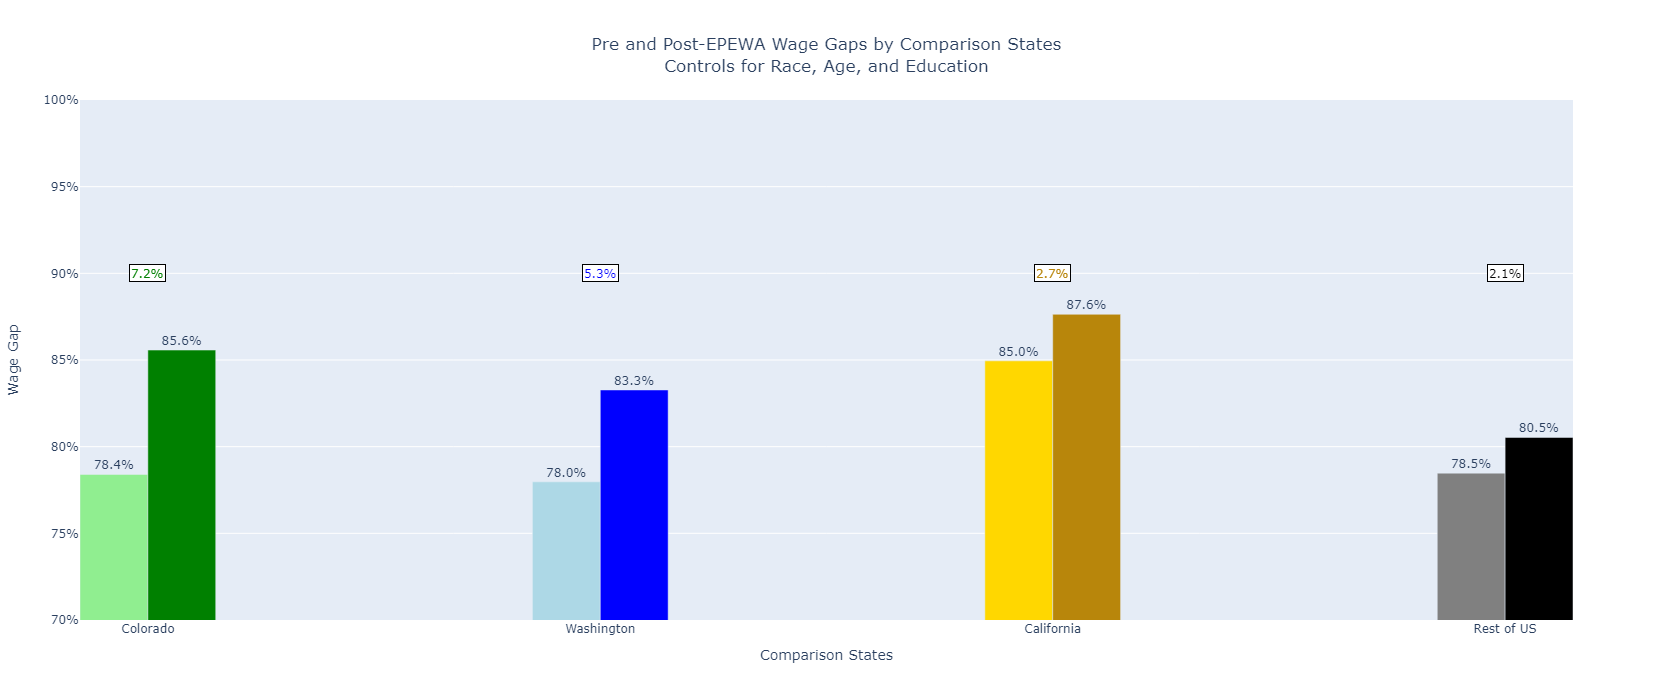

In [36]:
# Sorted categories from results_df
comp_cat4_categories = sorted(results_df.index)

# Sort by reduction
comp_cat4_categories = results_df.sort_values(by='interaction_coef', ascending=False).index

# Initialize color mapping
base_colors = {
    'Colorado': ('lightgreen', 'green'),
    'California': ('gold', 'darkgoldenrod'),
    'Washington': ('lightblue', 'blue'),
    'Rest of US': ('grey', 'black')
}
default_color = ('#D3D3D3', '#A9A9A9')

# Generate colors for each category
state_colors = {cat: default_color for cat in comp_cat4_categories}
for state, colors in base_colors.items():
    for cat in state_colors.keys():
        if state in cat:
            state_colors[cat] = colors

# Create figure with grouped bar chart
fig = go.Figure()

# Bar setup
bar_width = 0.15
bar_offset = bar_width / 2  # Adjust the offset to ensure bars don't overlap

for i, category in enumerate(comp_cat4_categories):
    pre_value = results_df.loc[category, 'pre_epewa_wage_gap']
    post_value = results_df.loc[category, 'post_epewa_wage_gap']
    pre_color, post_color = state_colors[category]
    fig.add_trace(go.Bar(
        x=[i - bar_offset],
        y=[pre_value],
        text=[f"{pre_value:.1%}"],  # Data label as percentage without decimal
        textposition='outside',
        name='Pre-EPEWA Wage Gap',
        marker_color=pre_color,
        width=bar_width,
        textfont=dict(size=12)
    ))
    fig.add_trace(go.Bar(
        x=[i + bar_offset],
        y=[post_value],
        text=[f"{post_value:.1%}"],  # Data label as percentage without decimal
        textposition='outside',
        name='Post-EPEWA Wage Gap',
        marker_color=post_color,
        width=bar_width,
        textfont=dict(size=12)
    ))
    
# Annotations setup
annotations = []

# You may need to adjust this depending on the specific values and desired appearance
annotation_y_position = 0.90  # Lower value to lower the annotation position

for i, category in enumerate(comp_cat4_categories):
    # Retrieve the interaction coefficient for the category
    interaction_value = results_df.loc[category, 'interaction_coef']
    # Retrieve the second color from the base_colors
    annotation_color = base_colors.get(category, ('#A9A9A9', '#A9A9A9'))[1]
    # Create an annotation for the interaction coefficient
    annotations.append(
        dict(
            x=i,  # Positioning on the x-axis (aligned with the category)
            y=annotation_y_position,  # Lowered y position for the annotation
            xref='x',
            yref='y',
            text=f"{interaction_value:.1%}",  # Interaction coefficient in .1% format
            showarrow=False,
            font=dict(
                size=12,  # Match the font size with the axis labels
                color=annotation_color  # Set color to match the second color in base_colors
            ),
            bgcolor='white',  # Background color for the annotation box
            bordercolor='black',  # Border color for the annotation box
            borderwidth=1
        )
    )

# Add annotations to the layout
fig.update_layout(annotations=annotations)

# Update layout for better readability and to adjust gaps
fig.update_layout(
    title='Pre and Post-EPEWA Wage Gaps by Comparison States<br>Controls for Race, Age, and Education',
    title_x=0.5,  # Center the title
    xaxis=dict(
        tickangle=0,
        title='Comparison States',
        tickvals=list(range(len(comp_cat4_categories))),
        ticktext=comp_cat4_categories
    ),
    yaxis=dict(
        title='Wage Gap',
        tickformat=".0%",  # Remove decimal places
        range=[0.7, 1]
    ),
    barmode='group',
    showlegend=False,
    bargap=0.05,  # Horizontal gap between different groups
    height=700,  # Make the graph taller
    autosize=True
)

fig.update_layout(width=800)

# Show the plot
fig.show()


The interaction coefficients are significant for all four comparison groups. Their relative values are consistent with the anticipated treatment effects.

In [76]:
# Define the formula for the regression model
formula = 'log_earnyear ~ C(female) + C(epewa) + C(female):C(epewa) + C(age) + C(race_cat) + C(educ) + C(ind_cat20_label)'

# Get unique categories in 'comp_cat4'
comp_cat4_categories = ipums_df['comp_cat4'].unique()
regression_results = {}

# Run the regression for each category in 'comp_cat4'
for category in comp_cat4_categories:
    subset = ipums_df[ipums_df['comp_cat4'] == category]
    
    # Check if there are enough records to run a regression
    if len(subset) > 1:
        model = smf.ols(formula, data=subset).fit(cov_type='HC3')
        
        # Store the coefficients for female and female:epewa interaction
        female_coef = model.params.get('C(female)[T.1]', None)
        interaction_coef = model.params.get('C(female)[T.1]:C(epewa)[T.1]', None)
        
        # Calculate the wage gap before and after considering epewa
        pre_epewa_wage_gap = 1 + female_coef
        post_epewa_wage_gap = pre_epewa_wage_gap + interaction_coef
        
        # Store results in the dictionary
        regression_results[category] = {
            'female_coef': female_coef,
            'interaction_coef': interaction_coef,
            'pre_epewa_wage_gap': pre_epewa_wage_gap,
            'post_epewa_wage_gap': post_epewa_wage_gap
        }

        print(f"Regression for comp_cat4 category {category}:, Industry Controls")
        display(model.summary())
        print("\n\n")

# Convert the results dictionary to a pandas DataFrame for easier handling
results_df = pd.DataFrame.from_dict(regression_results, orient='index')

# Display the stored data
print('Regression Results for Key Variables by comp_cat4 Category, Industry Controls')
display(results_df)


Regression for comp_cat4 category Rest of US:, Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     3663.
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:52:55   Log-Likelihood:            -2.6793e+05
No. Observations:              490706   AIC:                         5.360e+05
Df Residuals:                  490631   BIC:                         5.368e+05
Df Model:                          74                                         
Covariance Type:                  HC3                                         
===================================================================================================================================================================
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          10.0218      0.008   1233.406      0.000      10.006      10.038
C(female)[T.1]                                                                                     -0.1810      0.001   -126.105      0.000      -0.184      -0.178
C(epewa)[T.1]                                                                                       0.1867      0.002     90.770      0.000       0.183       0.191
C(age)[T.Age 25]                                                                                    0.0805      0.005     17.328      0.000       0.071       0.090
C(age)[T.Age 26]                                                                                    0.1113      0.005     24.173      0.000       0.102       0.120
C(age)[T.Age 27]                                                                                    0.1380      0.005     30.047      0.000       0.129       0.147
C(age)[T.Age 28]                                                                                    0.1503      0.005     32.694      0.000       0.141       0.159
C(age)[T.Age 29]                                                                                    0.1723      0.005     37.822      0.000       0.163       0.181
C(age)[T.Age 30]                                                                                    0.1798      0.005     39.402      0.000       0.171       0.189
C(age)[T.Age 31]                                                                                    0.2059      0.005     44.888      0.000       0.197       0.215
C(age)[T.Age 32]                                                                                    0.2226      0.005     48.575      0.000       0.214       0.232
C(age)[T.Age 33]                                                                                    0.2288      0.005     49.372      0.000       0.220       0.238
C(age)[T.Age 34]                                                                                    0.2407      0.005     51.626      0.000       0.232       0.250
C(age)[T.Age 35]                                                                                    0.2885      0.005     61.420      0.000       0.279       0.298
C(age)[T.Age 36]                                                                                    0.3047      0.005     64.586      0.000       0.295       0.314
C(age)[T.Age 37]                                                                                    0.3083      0.005     64.749   




Regression for comp_cat4 category California:, Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     413.8
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:52:57   Log-Likelihood:                -23276.
No. Observations:               44140   AIC:                         4.670e+04
Df Residuals:                   44065   BIC:                         4.735e+04
Df Model:                          74                                         
Covariance Type:                  HC3                                         
===================================================================================================================================================================
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          10.0756      0.021    488.489      0.000      10.035      10.116
C(female)[T.1]                                                                                     -0.1356      0.005    -29.051      0.000      -0.145      -0.126
C(epewa)[T.1]                                                                                       0.2008      0.006     31.281      0.000       0.188       0.213
C(age)[T.Age 25]                                                                                    0.0972      0.016      6.158      0.000       0.066       0.128
C(age)[T.Age 26]                                                                                    0.1275      0.016      8.064      0.000       0.097       0.158
C(age)[T.Age 27]                                                                                    0.1401      0.016      9.031      0.000       0.110       0.170
C(age)[T.Age 28]                                                                                    0.1658      0.015     10.698      0.000       0.135       0.196
C(age)[T.Age 29]                                                                                    0.1857      0.015     12.132      0.000       0.156       0.216
C(age)[T.Age 30]                                                                                    0.1954      0.015     12.765      0.000       0.165       0.225
C(age)[T.Age 31]                                                                                    0.2191      0.015     14.431      0.000       0.189       0.249
C(age)[T.Age 32]                                                                                    0.2466      0.016     15.820      0.000       0.216       0.277
C(age)[T.Age 33]                                                                                    0.2308      0.016     14.717      0.000       0.200       0.262
C(age)[T.Age 34]                                                                                    0.2589      0.016     16.335      0.000       0.228       0.290
C(age)[T.Age 35]                                                                                    0.2962      0.016     18.743      0.000       0.265       0.327
C(age)[T.Age 36]                                                                                    0.3302      0.016     21.047      0.000       0.299       0.361
C(age)[T.Age 37]                                                                                    0.3453      0.016     21.794   




Regression for comp_cat4 category Washington:, Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     80.34
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:52:58   Log-Likelihood:                -4674.4
No. Observations:                9537   AIC:                             9499.
Df Residuals:                    9462   BIC:                         1.004e+04
Df Model:                          74                                         
Covariance Type:                  HC3                                         
===================================================================================================================================================================
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          10.1822      0.051    199.202      0.000      10.082      10.282
C(female)[T.1]                                                                                     -0.1775      0.010    -17.877      0.000      -0.197      -0.158
C(epewa)[T.1]                                                                                       0.2052      0.013     15.686      0.000       0.180       0.231
C(age)[T.Age 25]                                                                                    0.0867      0.031      2.792      0.005       0.026       0.148
C(age)[T.Age 26]                                                                                    0.1316      0.033      3.978      0.000       0.067       0.196
C(age)[T.Age 27]                                                                                    0.1693      0.032      5.323      0.000       0.107       0.232
C(age)[T.Age 28]                                                                                    0.1838      0.031      5.837      0.000       0.122       0.246
C(age)[T.Age 29]                                                                                    0.1839      0.032      5.691      0.000       0.121       0.247
C(age)[T.Age 30]                                                                                    0.2111      0.031      6.724      0.000       0.150       0.273
C(age)[T.Age 31]                                                                                    0.2766      0.032      8.742      0.000       0.215       0.339
C(age)[T.Age 32]                                                                                    0.2464      0.031      7.921      0.000       0.185       0.307
C(age)[T.Age 33]                                                                                    0.2575      0.032      8.161      0.000       0.196       0.319
C(age)[T.Age 34]                                                                                    0.3005      0.031      9.630      0.000       0.239       0.362
C(age)[T.Age 35]                                                                                    0.3122      0.031     10.070      0.000       0.251       0.373
C(age)[T.Age 36]                                                                                    0.3184      0.032      9.965      0.000       0.256       0.381
C(age)[T.Age 37]                                                                                    0.3211      0.033      9.869   




Regression for comp_cat4 category Colorado:, Industry Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     82.78
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:52:58   Log-Likelihood:                -5076.7
No. Observations:                9605   AIC:                         1.030e+04
Df Residuals:                    9530   BIC:                         1.084e+04
Df Model:                          74                                         
Covariance Type:                  HC3                                         
===================================================================================================================================================================
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          10.0368      0.060    166.731      0.000       9.919      10.155
C(female)[T.1]                                                                                     -0.1753      0.010    -17.447      0.000      -0.195      -0.156
C(epewa)[T.1]                                                                                       0.2159      0.016     13.526      0.000       0.185       0.247
C(age)[T.Age 25]                                                                                    0.1475      0.033      4.506      0.000       0.083       0.212
C(age)[T.Age 26]                                                                                    0.0896      0.031      2.916      0.004       0.029       0.150
C(age)[T.Age 27]                                                                                    0.1461      0.032      4.599      0.000       0.084       0.208
C(age)[T.Age 28]                                                                                    0.2299      0.031      7.397      0.000       0.169       0.291
C(age)[T.Age 29]                                                                                    0.2077      0.030      6.813      0.000       0.148       0.267
C(age)[T.Age 30]                                                                                    0.2003      0.031      6.535      0.000       0.140       0.260
C(age)[T.Age 31]                                                                                    0.2138      0.030      7.162      0.000       0.155       0.272
C(age)[T.Age 32]                                                                                    0.2559      0.031      8.365      0.000       0.196       0.316
C(age)[T.Age 33]                                                                                    0.2808      0.030      9.343      0.000       0.222       0.340
C(age)[T.Age 34]                                                                                    0.2778      0.032      8.789      0.000       0.216       0.340
C(age)[T.Age 35]                                                                                    0.3073      0.032      9.697      0.000       0.245       0.369
C(age)[T.Age 36]                                                                                    0.4159      0.033     12.517      0.000       0.351       0.481
C(age)[T.Age 37]                                                                                    0.3625      0.033     11.145   




Regression Results for Key Variables by comp_cat4 Category, Industry Controls


female_coef  interaction_coef  pre_epewa_wage_gap  \
Rest of US      -0.1810            0.0239              0.8190   
California      -0.1356            0.0300              0.8644   
Washington      -0.1775            0.0635              0.8225   
Colorado        -0.1753            0.0671              0.8247   

            post_epewa_wage_gap  
Rest of US               0.8428  
California               0.8944  
Washington               0.8860  
Colorado                 0.8918

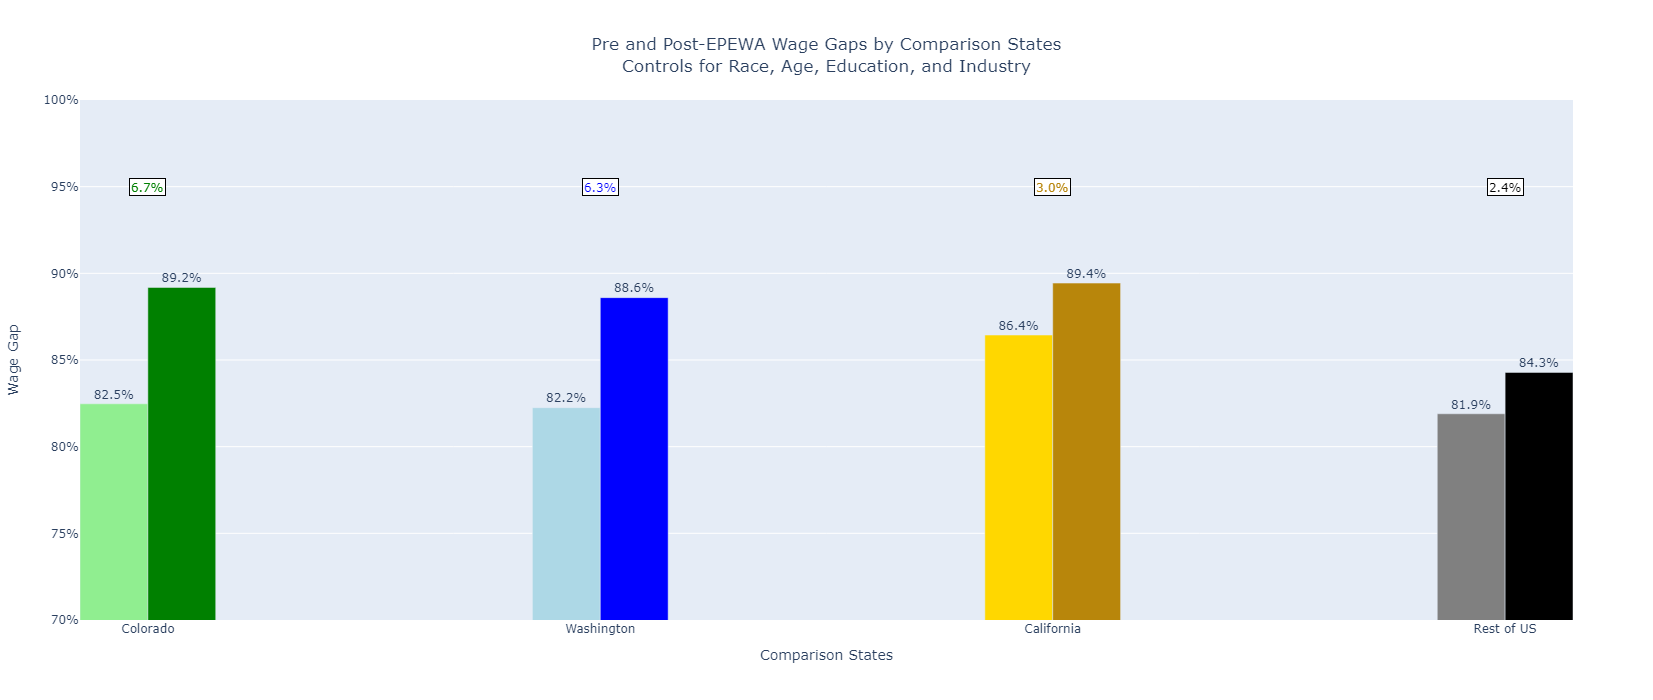

In [77]:
# Sorted categories from results_df
comp_cat4_categories = sorted(results_df.index)

# Sort by reduction
comp_cat4_categories = results_df.sort_values(by='interaction_coef', ascending=False).index

# Initialize color mapping
base_colors = {
    'Colorado': ('lightgreen', 'green'),
    'California': ('gold', 'darkgoldenrod'),
    'Washington': ('lightblue', 'blue'),
    'Rest of US': ('grey', 'black')
}
default_color = ('#D3D3D3', '#A9A9A9')

# Generate colors for each category
state_colors = {cat: default_color for cat in comp_cat4_categories}
for state, colors in base_colors.items():
    for cat in state_colors.keys():
        if state in cat:
            state_colors[cat] = colors

# Create figure with grouped bar chart
fig = go.Figure()

# Bar setup
bar_width = 0.15
bar_offset = bar_width / 2  # Adjust the offset to ensure bars don't overlap

for i, category in enumerate(comp_cat4_categories):
    pre_value = results_df.loc[category, 'pre_epewa_wage_gap']
    post_value = results_df.loc[category, 'post_epewa_wage_gap']
    pre_color, post_color = state_colors[category]
    fig.add_trace(go.Bar(
        x=[i - bar_offset],
        y=[pre_value],
        text=[f"{pre_value:.1%}"],  # Data label as percentage without decimal
        textposition='outside',
        name='Pre-EPEWA Wage Gap',
        marker_color=pre_color,
        width=bar_width,
        textfont=dict(size=12)
    ))
    fig.add_trace(go.Bar(
        x=[i + bar_offset],
        y=[post_value],
        text=[f"{post_value:.1%}"],  # Data label as percentage without decimal
        textposition='outside',
        name='Post-EPEWA Wage Gap',
        marker_color=post_color,
        width=bar_width,
        textfont=dict(size=12)
    ))
    
# Annotations setup
annotations = []

# You may need to adjust this depending on the specific values and desired appearance
annotation_y_position = 0.95  # Lower value to lower the annotation position

for i, category in enumerate(comp_cat4_categories):
    # Retrieve the interaction coefficient for the category
    interaction_value = results_df.loc[category, 'interaction_coef']
    # Retrieve the second color from the base_colors
    annotation_color = base_colors.get(category, ('#A9A9A9', '#A9A9A9'))[1]
    # Create an annotation for the interaction coefficient
    annotations.append(
        dict(
            x=i,  # Positioning on the x-axis (aligned with the category)
            y=annotation_y_position,  # Lowered y position for the annotation
            xref='x',
            yref='y',
            text=f"{interaction_value:.1%}",  # Interaction coefficient in .1% format
            showarrow=False,
            font=dict(
                size=12,  # Match the font size with the axis labels
                color=annotation_color  # Set color to match the second color in base_colors
            ),
            bgcolor='white',  # Background color for the annotation box
            bordercolor='black',  # Border color for the annotation box
            borderwidth=1
        )
    )

# Add annotations to the layout
fig.update_layout(annotations=annotations)

# Update layout for better readability and to adjust gaps
fig.update_layout(
    title='Pre and Post-EPEWA Wage Gaps by Comparison States<br>Controls for Race, Age, Education, and Industry',
    title_x=0.5,  # Center the title
    xaxis=dict(
        tickangle=0,
        title='Comparison States',
        tickvals=list(range(len(comp_cat4_categories))),
        ticktext=comp_cat4_categories
    ),
    yaxis=dict(
        title='Wage Gap',
        tickformat=".0%",  # Remove decimal places
        range=[0.7, 1]
    ),
    barmode='group',
    showlegend=False,
    bargap=0.05,  # Horizontal gap between different groups
    height=700,  # Make the graph taller
    autosize=True
)

fig.update_layout(width=1100)

# Show the plot
fig.show()


# Section 5: State Ranking and Charts

This section of code adds names to the dataset for each individual state (this code could be moved to section 3 but wasn't needed until this point). 

To evaluate how the states rank against each other and the national average for the gender wage gap, the code then runs the regression model for each state and compiles the results into a dataframe. In this dataframe, the code quantifies the measurements of the gender wage gap into the typical 'cents on the dollar' interpretation (women's earnings as a percentage of men's). To evaluate the effects of EPEWA, the code adds the change to the pre-trend value to approximate an after EPEWA value. The code notes any of these approximations where the coefficient of the change was not statistically significant at the 10% level and charts the ranking.

This process is repeated with and without industry controls.

In [39]:
# Give state names to the STATEFIP codes in the ipums_df
# This step could be moved up to the merge between the minwage DF and the IPUMS DF for clarity
# It isn't necessary until this part of the analysis.

state_fip_mapping = {
    '01': 'Alabama',
    '02': 'Alaska',
    '04': 'Arizona',
    '05': 'Arkansas',
    '06': 'California',
    '08': 'Colorado',
    '09': 'Connecticut',
    '10': 'Delaware',
    '11': 'District of Columbia',
    '12': 'Florida',
    '13': 'Georgia',
    '15': 'Hawaii',
    '16': 'Idaho',
    '17': 'Illinois',
    '18': 'Indiana',
    '19': 'Iowa',
    '20': 'Kansas',
    '21': 'Kentucky',
    '22': 'Louisiana',
    '23': 'Maine',
    '24': 'Maryland',
    '25': 'Massachusetts',
    '26': 'Michigan',
    '27': 'Minnesota',
    '28': 'Mississippi',
    '29': 'Missouri',
    '30': 'Montana',
    '31': 'Nebraska',
    '32': 'Nevada',
    '33': 'New Hampshire',
    '34': 'New Jersey',
    '35': 'New Mexico',
    '36': 'New York',
    '37': 'North Carolina',
    '38': 'North Dakota',
    '39': 'Ohio',
    '40': 'Oklahoma',
    '41': 'Oregon',
    '42': 'Pennsylvania',
    '44': 'Rhode Island',
    '45': 'South Carolina',
    '46': 'South Dakota',
    '47': 'Tennessee',
    '48': 'Texas',
    '49': 'Utah',
    '50': 'Vermont',
    '51': 'Virginia',
    '53': 'Washington',
    '54': 'West Virginia',
    '55': 'Wisconsin',
    '56': 'Wyoming'
}

# Ensure the STATEFIP codes are strings and have leading zeros if necessary

ipums_df['STATEFIP'] = ipums_df['STATEFIP'].astype(str).str.pad(2, fillchar='0')

# Map the STATEFIP codes to state names and create the 'state' column

ipums_df['state'] = ipums_df['STATEFIP'].map(state_fip_mapping)

# Convert the 'state' column to a categorical type

ipums_df['state'] = ipums_df['state'].astype('category')

# Verify the mapping

display(ipums_df[['STATEFIP', 'state']].head())

STATEFIP        state
0       01      Alabama
1       01      Alabama
2       01      Alabama
3       09  Connecticut
4       09  Connecticut

In [65]:
# The following code runs the regression for each state
# There are not industry controls in this analysis
# Define the formula for the regression model

formula = 'log_earnyear ~ C(female) + C(epewa) + C(female):C(epewa) + C(age) + C(race_cat) + C(educ)'

state_categories = ipums_df['state'].cat.categories
regression_results = {}

# Run the regression for each state

for state in state_categories:
    subset = ipums_df[ipums_df['state'] == state]
    
    # Check if there are enough records to run a regression
    
    if len(subset) > 1:
        model = smf.ols(formula, data=subset).fit(cov_type='HC3')
        
        # Store the coefficients and p-values for the variables of interest
        
        regression_results[state] = {
            'female_coef': model.params.get('C(female)[T.1]', None),
            'female_pval': model.pvalues.get('C(female)[T.1]', None),
            'interaction_coef': model.params.get('C(female)[T.1]:C(epewa)[T.1]', None),
            'interaction_pval': model.pvalues.get('C(female)[T.1]:C(epewa)[T.1]', None)
        }

# Convert the results dictionary to a pandas DataFrame for easier handling

results_df = pd.DataFrame.from_dict(regression_results, orient='index')

# Run the regression for the entire sample

national_model = smf.ols(formula, data=ipums_df).fit(cov_type='HC3')

# Store the national coefficients and p-values

national_results = {
    'female_coef': national_model.params.get('C(female)[T.1]', None),
    'female_pval': national_model.pvalues.get('C(female)[T.1]', None),
    'interaction_coef': national_model.params.get('C(female)[T.1]:C(epewa)[T.1]', None),
    'interaction_pval': national_model.pvalues.get('C(female)[T.1]:C(epewa)[T.1]', None)
}

# Add the national results to the results_df with the state value 'United States'

results_df.loc['United States'] = national_results

# Display the stored coefficients and p-values

print('Individual State Regression Results for Key Variables, No Industry Controls')
display(results_df)


Individual State Regression Results for Key Variables, No Industry Controls


female_coef  female_pval  interaction_coef  \
Alabama                   -0.2541       0.0000            0.0254   
Alaska                    -0.2340       0.0000            0.0757   
Arizona                   -0.1734       0.0000           -0.0156   
Arkansas                  -0.2139       0.0000            0.0546   
California                -0.1505       0.0000            0.0269   
Colorado                  -0.2160       0.0000            0.0718   
Connecticut               -0.1906       0.0000            0.0124   
Delaware                  -0.1738       0.0000            0.0445   
District of Columbia      -0.0680       0.0000           -0.0027   
Florida                   -0.1736       0.0000            0.0324   
Georgia                   -0.2310       0.0000            0.0254   
Hawaii                    -0.1893       0.0000            0.0395   
Idaho                     -0.2383       0.0000            0.0140   
Illinois                  -0.1909       0.0000            0.0036   
Indiana                   -0.2627       0.0000            0.0462   
Iowa                      -0.2420       0.0000           -0.0095   
Kansas                    -0.2345       0.0000            0.0197   
Kentucky                  -0.2217       0.0000            0.0003   
Louisiana                 -0.2658       0.0000           -0.0281   
Maine                     -0.2266       0.0000            0.0223   
Maryland                  -0.1701       0.0000            0.0139   
Massachusetts             -0.1776       0.0000            0.0559   
Michigan                  -0.2212       0.0000            0.0473   
Minnesota                 -0.1902       0.0000            0.0237   
Mississippi               -0.2374       0.0000           -0.0075   
Missouri                  -0.2340       0.0000            0.0009   
Montana                   -0.2166       0.0000            0.0103   
Nebraska                  -0.2085       0.0000           -0.0090   
Nevada                    -0.1965       0.0000            0.0133   
New Hampshire             -0.2456       0.0000            0.0074   
New Jersey                -0.1858       0.0000            0.0232   
New Mexico                -0.2071       0.0000            0.0288   
New York                  -0.1716       0.0000            0.0269   
North Carolina            -0.1891       0.0000            0.0230   
North Dakota              -0.2726       0.0000            0.0740   
Ohio                      -0.2206       0.0000            0.0197   
Oklahoma                  -0.2557       0.0000           -0.0344   
Oregon                    -0.1833       0.0000            0.0349   
Pennsylvania              -0.2301       0.0000            0.0521   
Rhode Island              -0.2053       0.0000            0.0527   
South Carolina            -0.2309       0.0000            0.0382   
South Dakota              -0.2612       0.0000            0.0715   
Tennessee                 -0.2140       0.0000           -0.0063   
Texas                     -0.2261       0.0000            0.0227   
Utah                      -0.2590       0.0000            0.0417   
Vermont                   -0.1855       0.0000            0.0127   
Virginia                  -0.2191       0.0000            0.0434   
Washington                -0.2203       0.0000            0.0530   
West Virginia             -0.2672       0.0000            0.0214   
Wisconsin                 -0.2201       0.0000            0.0361   
Wyoming                   -0.3435       0.0000            0.0647   
United States             -0.2107       0.0000            0.0220   

                      interaction_pval  
Alabama                         0.1912  
Alaska                          0.0028  
Arizona                         0.4716  
Arkansas                        0.0108  
California                      0.0048  
Colorado                        0.0024  
Connecticut                     0.6553  
Delaware                        0.1037  
District of Columbia            0.8819  
Florida

In [66]:
# Sort the results and rename variables based on the 'cents on the dollar' interpretation

wage_gap_ranking = results_df.copy()
wage_gap_ranking['Pre_EPEWA_Gap'] = wage_gap_ranking['female_coef'] + 1
wage_gap_ranking['Post_EPEWA_Gap'] = wage_gap_ranking['Pre_EPEWA_Gap'] + wage_gap_ranking['interaction_coef']
display(wage_gap_ranking)

female_coef  female_pval  interaction_coef  \
Alabama                   -0.2541       0.0000            0.0254   
Alaska                    -0.2340       0.0000            0.0757   
Arizona                   -0.1734       0.0000           -0.0156   
Arkansas                  -0.2139       0.0000            0.0546   
California                -0.1505       0.0000            0.0269   
Colorado                  -0.2160       0.0000            0.0718   
Connecticut               -0.1906       0.0000            0.0124   
Delaware                  -0.1738       0.0000            0.0445   
District of Columbia      -0.0680       0.0000           -0.0027   
Florida                   -0.1736       0.0000            0.0324   
Georgia                   -0.2310       0.0000            0.0254   
Hawaii                    -0.1893       0.0000            0.0395   
Idaho                     -0.2383       0.0000            0.0140   
Illinois                  -0.1909       0.0000            0.0036   
Indiana                   -0.2627       0.0000            0.0462   
Iowa                      -0.2420       0.0000           -0.0095   
Kansas                    -0.2345       0.0000            0.0197   
Kentucky                  -0.2217       0.0000            0.0003   
Louisiana                 -0.2658       0.0000           -0.0281   
Maine                     -0.2266       0.0000            0.0223   
Maryland                  -0.1701       0.0000            0.0139   
Massachusetts             -0.1776       0.0000            0.0559   
Michigan                  -0.2212       0.0000            0.0473   
Minnesota                 -0.1902       0.0000            0.0237   
Mississippi               -0.2374       0.0000           -0.0075   
Missouri                  -0.2340       0.0000            0.0009   
Montana                   -0.2166       0.0000            0.0103   
Nebraska                  -0.2085       0.0000           -0.0090   
Nevada                    -0.1965       0.0000            0.0133   
New Hampshire             -0.2456       0.0000            0.0074   
New Jersey                -0.1858       0.0000            0.0232   
New Mexico                -0.2071       0.0000            0.0288   
New York                  -0.1716       0.0000            0.0269   
North Carolina            -0.1891       0.0000            0.0230   
North Dakota              -0.2726       0.0000            0.0740   
Ohio                      -0.2206       0.0000            0.0197   
Oklahoma                  -0.2557       0.0000           -0.0344   
Oregon                    -0.1833       0.0000            0.0349   
Pennsylvania              -0.2301       0.0000            0.0521   
Rhode Island              -0.2053       0.0000            0.0527   
South Carolina            -0.2309       0.0000            0.0382   
South Dakota              -0.2612       0.0000            0.0715   
Tennessee                 -0.2140       0.0000           -0.0063   
Texas                     -0.2261       0.0000            0.0227   
Utah                      -0.2590       0.0000            0.0417   
Vermont                   -0.1855       0.0000            0.0127   
Virginia                  -0.2191       0.0000            0.0434   
Washington                -0.2203       0.0000            0.0530   
West Virginia             -0.2672       0.0000            0.0214   
Wisconsin                 -0.2201       0.0000            0.0361   
Wyoming                   -0.3435       0.0000            0.0647   
United States             -0.2107       0.0000            0.0220   

                      interaction_pval  Pre_EPEWA_Gap  Post_EPEWA_Gap  
Alabama                         0.1912         0.7459          0.7714  
Alaska                          0.0028         0.7660          0.8417  
Arizona                         0.4716         0.8266          0.8111  
Arkansas                        0.0108         0.7861          0.8408  
California                      0.0048         0.8495    

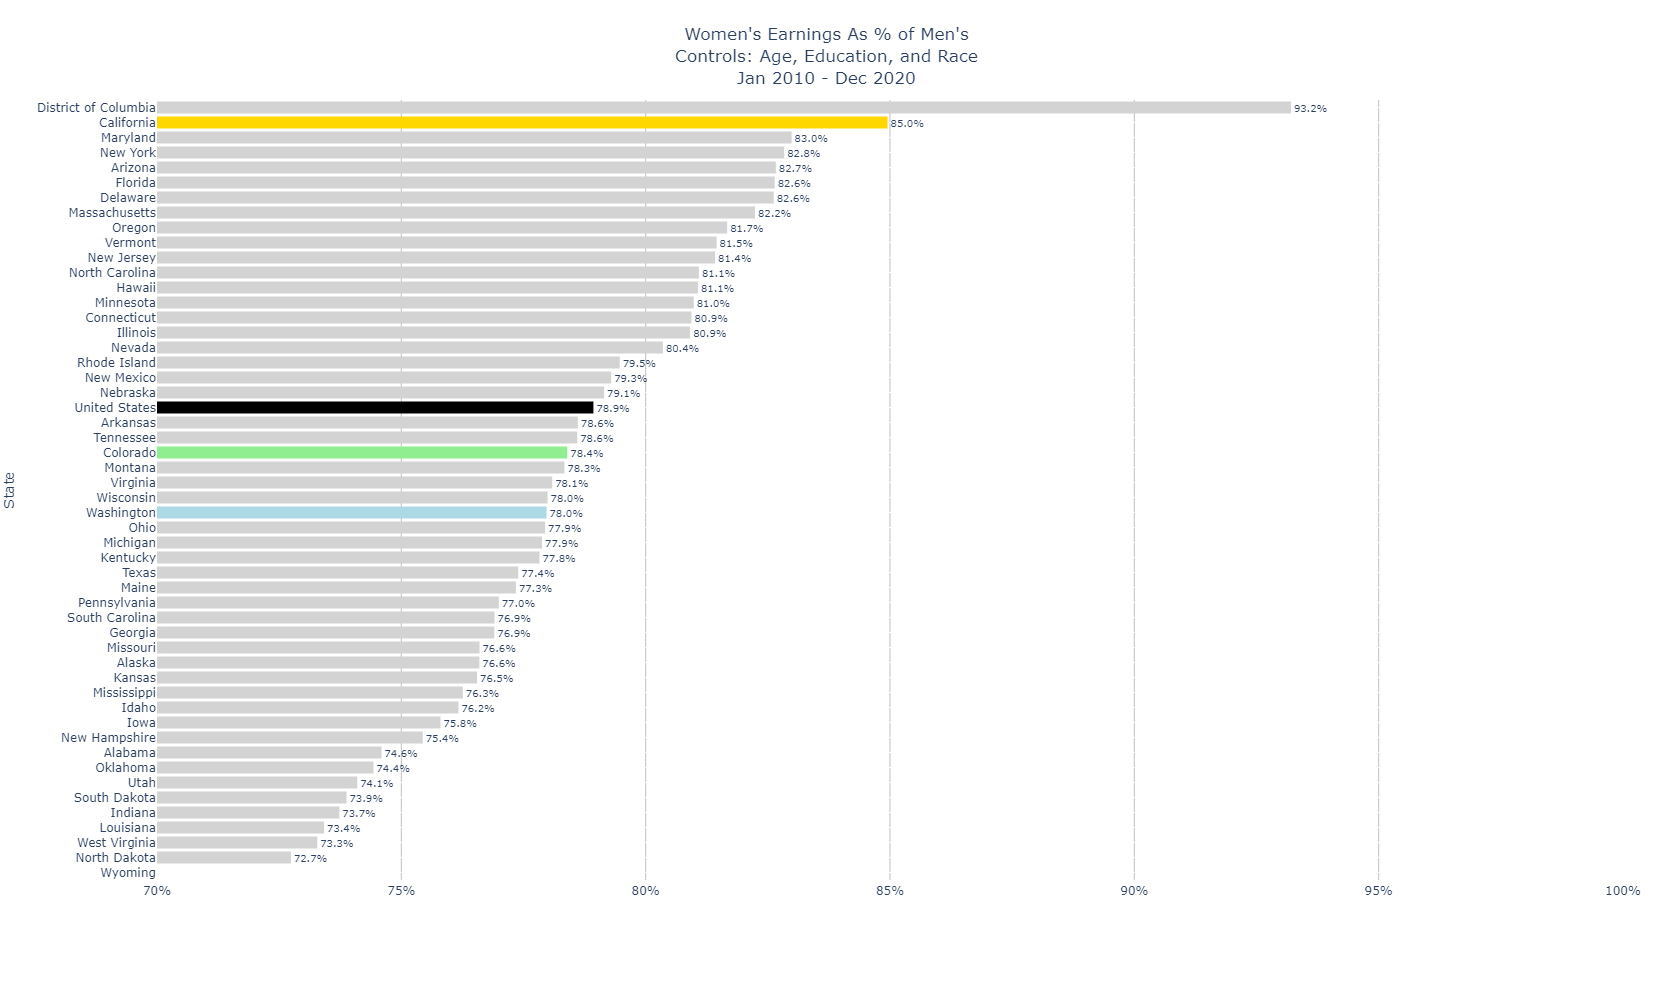

In [67]:
# The following code creates a chart of the results and notes the statistically insignificant results with an asterisks
# Remove existing asterisks from the state names to avoid duplication

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

# Sort wage_gap_ranking by Post_EPEWA_Gap

wage_gap_ranking = wage_gap_ranking.sort_values(by='Pre_EPEWA_Gap', ascending=True)

# Define the color for each state

state_colors = ['#D3D3D3'] * len(wage_gap_ranking)
for i, state in enumerate(wage_gap_ranking.index):
    if 'Colorado' in state:
        state_colors[i] = 'lightgreen'
    elif 'California' in state:
        state_colors[i] = 'gold'
    elif 'Washington' in state:
        state_colors[i] = 'lightblue'
    elif 'United States' in state:
        state_colors[i] = 'black'

# Add asterisks based on the female_pval

wage_gap_ranking.index = [
    f"{state}*" if pval > 0.10 else state 
    for state, pval in zip(wage_gap_ranking.index, wage_gap_ranking['female_pval'])
]

# Sort wage_gap_ranking by Pre_EPEWA_Gap

wage_gap_ranking = wage_gap_ranking.sort_values(by='Pre_EPEWA_Gap', ascending=True)

# Convert Pre_EPEWA_Gap to percentage text for callouts

percentage_labels = wage_gap_ranking['Pre_EPEWA_Gap'].map(lambda x: '{:,.1f}%'.format(x * 100)).values

# Create the bar chart

fig = go.Figure(go.Bar(
    x=wage_gap_ranking['Pre_EPEWA_Gap'],
    y=wage_gap_ranking.index,
    orientation='h',
    marker=dict(color=state_colors),
    text=percentage_labels,  # Add percentage labels as text
    textposition='outside'  # Position the text at the end of the bars# Set bar colors based on state
))

# Update the layout to match the desired style

fig.update_layout(
    title={
        'text': "Women's Earnings As % of Men's<br>Controls: Age, Education, and Race<br>Jan 2010 - Dec 2020",
        'y': 0.96,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="State",
    xaxis=dict(
        showgrid=True,
        showline=True,
        gridcolor='grey',
        gridwidth=0.5,
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='grey',
        range=[0.7, 1],
        tickformat='.0%',
    ),
    yaxis=dict(
        showgrid=True,
        showline=False
    ),
    bargap=0.2,
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=20, r=20, t=100, b=120),
)

fig.update_traces(marker_line_width=0)

fig.show()

# Remove asterisks again for clean future runs

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

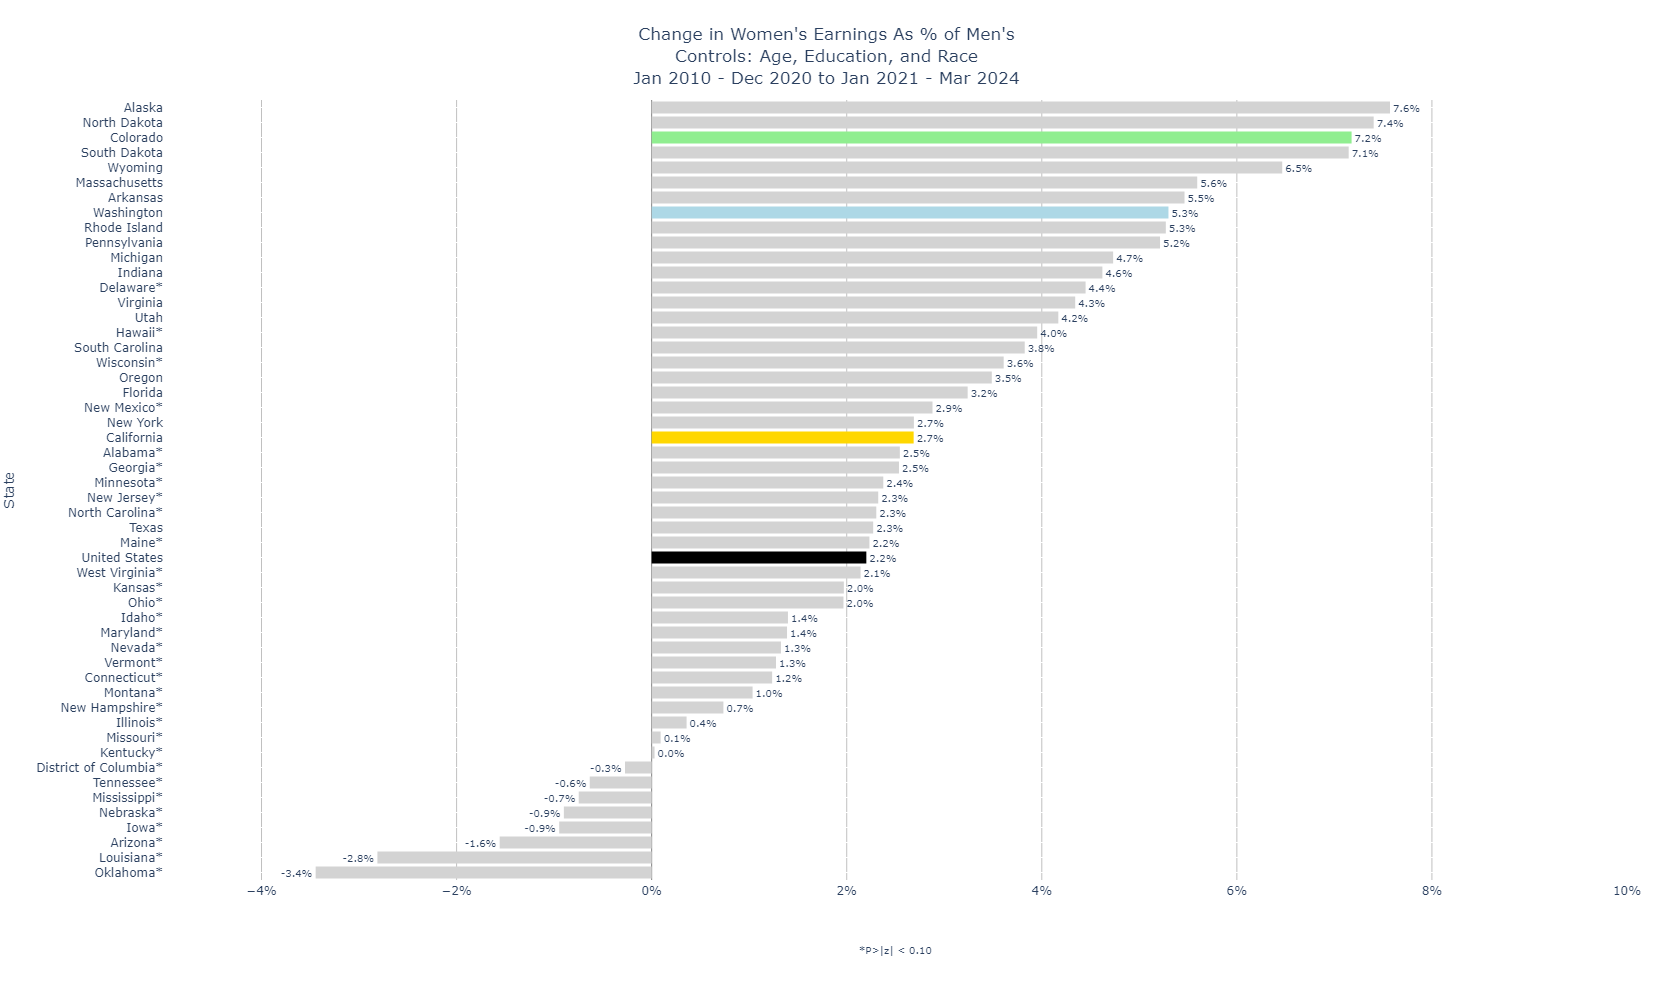

In [68]:
# The following code produces the same chart for the change from before and after the law

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

wage_gap_ranking = wage_gap_ranking.sort_values(by='interaction_coef', ascending=True)

state_colors = ['#D3D3D3'] * len(wage_gap_ranking)
for i, state in enumerate(wage_gap_ranking.index):
    if 'Colorado' in state:
        state_colors[i] = 'lightgreen'
    elif 'California' in state:
        state_colors[i] = 'gold'
    elif 'Washington' in state:
        state_colors[i] = 'lightblue'
    elif 'United States' in state:
        state_colors[i] = 'black'

wage_gap_ranking.index = [
    f"{state}*" if pval > 0.10 else state 
    for state, pval in zip(wage_gap_ranking.index, wage_gap_ranking['interaction_pval'])
]

wage_gap_ranking = wage_gap_ranking.sort_values(by='interaction_coef', ascending=True)

percentage_labels = wage_gap_ranking['interaction_coef'].map(lambda x: '{:,.1f}%'.format(x * 100)).values

fig = go.Figure(go.Bar(
    x=wage_gap_ranking['interaction_coef'],
    y=wage_gap_ranking.index,
    orientation='h',
    marker=dict(color=state_colors),
    text=percentage_labels,
    textposition='outside'
))

fig.update_layout(
    title={
        'text': "Change in Women's Earnings As % of Men's<br>Controls: Age, Education, and Race<br>Jan 2010 - Dec 2020 to Jan 2021 - Mar 2024",
        'y': 0.96,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="State",
    xaxis=dict(
        showgrid=True,
        showline=True,
        gridcolor='grey',
        gridwidth=0.5,
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='grey',
        range=[-0.05, .1],
        tickformat='.0%',
    ),
    yaxis=dict(
        showgrid=True,
        showline=False
    ),
    bargap=0.2,
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=20, r=20, t=100, b=120),
    annotations=[  # Add note regarding p-value
        dict(
             text="*P>|z| < 0.10",
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            showarrow=False,
            font=dict(size=10),
            align='center'
        )
    ]
)

fig.update_traces(marker_line_width=0)

fig.show()

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

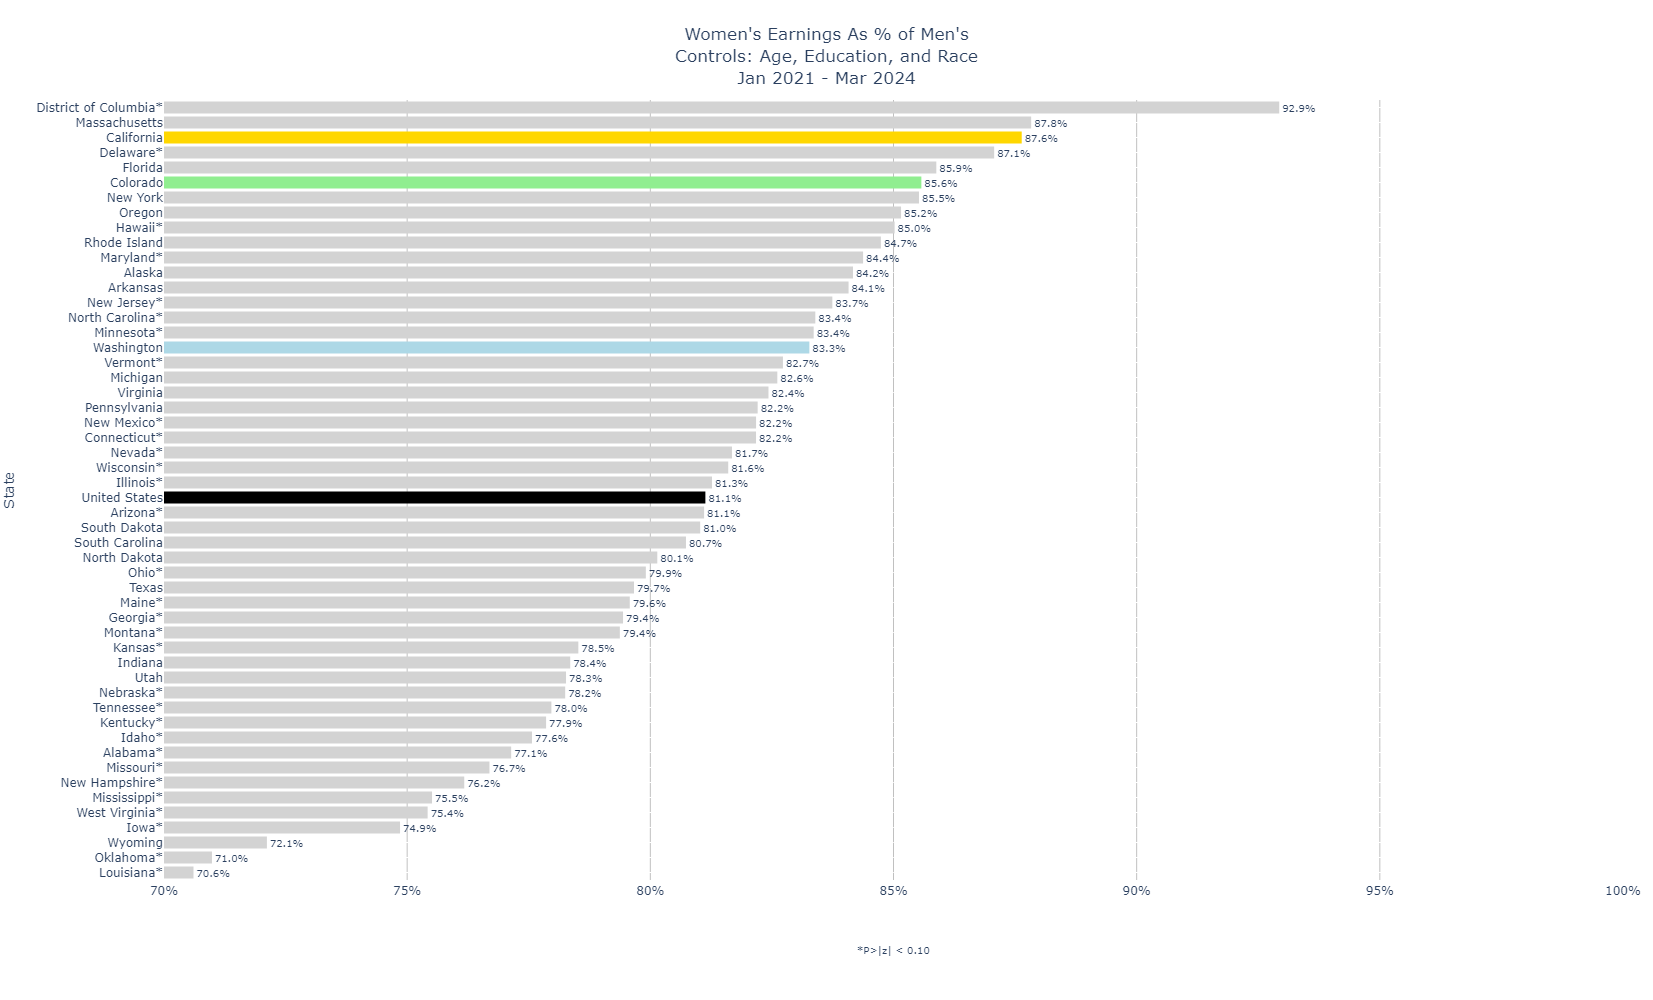

In [69]:
# The following chart shows the sum of the pre-law and change


wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

wage_gap_ranking = wage_gap_ranking.sort_values(by='Post_EPEWA_Gap', ascending=True)

state_colors = ['#D3D3D3'] * len(wage_gap_ranking)
for i, state in enumerate(wage_gap_ranking.index):
    if 'Colorado' in state:
        state_colors[i] = 'lightgreen'
    elif 'California' in state:
        state_colors[i] = 'gold'
    elif 'Washington' in state:
        state_colors[i] = 'lightblue'
    elif 'United States' in state:
        state_colors[i] = 'black'


wage_gap_ranking.index = [
    f"{state}*" if pval > 0.10 else state 
    for state, pval in zip(wage_gap_ranking.index, wage_gap_ranking['interaction_pval'])
]

wage_gap_ranking = wage_gap_ranking.sort_values(by='Post_EPEWA_Gap', ascending=True)

percentage_labels = wage_gap_ranking['Post_EPEWA_Gap'].map(lambda x: '{:,.1f}%'.format(x * 100)).values

fig = go.Figure(go.Bar(
    x=wage_gap_ranking['Post_EPEWA_Gap'],
    y=wage_gap_ranking.index,
    orientation='h',
    marker=dict(color=state_colors),
    text=percentage_labels,
    textposition='outside'
))

fig.update_layout(
    title={
        'text': "Women's Earnings As % of Men's<br>Controls: Age, Education, and Race<br>Jan 2021 - Mar 2024",
        'y': 0.96,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="State",
    xaxis=dict(
        showgrid=True,
        showline=True,
        gridcolor='grey',
        gridwidth=0.5,
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='grey',
        range=[0.7, 1],
        tickformat='.0%',
    ),
    yaxis=dict(
        showgrid=True,
        showline=False
    ),
    bargap=0.2,
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=20, r=20, t=100, b=120),
    annotations=[
        dict(
             text="*P>|z| < 0.10",
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            showarrow=False,
            font=dict(size=10),
            align='center'
        )
    ]
)

fig.update_traces(marker_line_width=0)

fig.show()

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

In [70]:
# The next several blocks of code recreate the same results, this time with industry controls
# This the preferred specification

formula = 'log_earnyear ~ C(female) + C(epewa) + C(female):C(epewa) + C(age) + C(ind_cat20_label) + C(race_cat) + C(educ)'

state_categories = ipums_df['state'].cat.categories

regression_results = {}

for state in state_categories:
    subset = ipums_df[ipums_df['state'] == state]
    if len(subset) > 1:
        model = smf.ols(formula, data=subset).fit(cov_type='HC3')
        regression_results[state] = {
            'female_coef': model.params.get('C(female)[T.1]', None),
            'female_pval': model.pvalues.get('C(female)[T.1]', None),
            'interaction_coef': model.params.get('C(female)[T.1]:C(epewa)[T.1]', None),
            'interaction_pval': model.pvalues.get('C(female)[T.1]:C(epewa)[T.1]', None)
        }

results_df = pd.DataFrame.from_dict(regression_results, orient='index')

national_model = smf.ols(formula, data=ipums_df).fit(cov_type='HC3')

national_results = {
    'female_coef': national_model.params.get('C(female)[T.1]', None),
    'female_pval': national_model.pvalues.get('C(female)[T.1]', None),
    'interaction_coef': national_model.params.get('C(female)[T.1]:C(epewa)[T.1]', None),
    'interaction_pval': national_model.pvalues.get('C(female)[T.1]:C(epewa)[T.1]', None)
}

results_df.loc['United States'] = national_results

display(results_df)

female_coef  female_pval  interaction_coef  \
Alabama                   -0.2221       0.0000            0.0266   
Alaska                    -0.1919       0.0000            0.0788   
Arizona                   -0.1469       0.0000           -0.0143   
Arkansas                  -0.1847       0.0000            0.0542   
California                -0.1356       0.0000            0.0300   
Colorado                  -0.1753       0.0000            0.0671   
Connecticut               -0.1710       0.0000            0.0149   
Delaware                  -0.1607       0.0000            0.0602   
District of Columbia      -0.0554       0.0000            0.0006   
Florida                   -0.1663       0.0000            0.0323   
Georgia                   -0.2099       0.0000            0.0269   
Hawaii                    -0.1665       0.0000            0.0482   
Idaho                     -0.2088       0.0000            0.0143   
Illinois                  -0.1529       0.0000            0.0046   
Indiana                   -0.2293       0.0000            0.0529   
Iowa                      -0.2047       0.0000            0.0076   
Kansas                    -0.1846       0.0000            0.0056   
Kentucky                  -0.1773       0.0000           -0.0016   
Louisiana                 -0.2043       0.0000           -0.0280   
Maine                     -0.1835       0.0000            0.0179   
Maryland                  -0.1392       0.0000            0.0227   
Massachusetts             -0.1440       0.0000            0.0593   
Michigan                  -0.1846       0.0000            0.0502   
Minnesota                 -0.1538       0.0000            0.0266   
Mississippi               -0.2031       0.0000           -0.0016   
Missouri                  -0.1917       0.0000            0.0064   
Montana                   -0.1725       0.0000            0.0176   
Nebraska                  -0.1706       0.0000           -0.0065   
Nevada                    -0.1721       0.0000            0.0143   
New Hampshire             -0.2067       0.0000            0.0117   
New Jersey                -0.1651       0.0000            0.0261   
New Mexico                -0.1673       0.0000            0.0311   
New York                  -0.1488       0.0000            0.0354   
North Carolina            -0.1734       0.0000            0.0279   
North Dakota              -0.1969       0.0000            0.0671   
Ohio                      -0.1844       0.0000            0.0234   
Oklahoma                  -0.2022       0.0000           -0.0364   
Oregon                    -0.1509       0.0000            0.0484   
Pennsylvania              -0.1968       0.0000            0.0573   
Rhode Island              -0.1739       0.0000            0.0571   
South Carolina            -0.2048       0.0000            0.0427   
South Dakota              -0.2336       0.0000            0.0739   
Tennessee                 -0.1841       0.0000           -0.0043   
Texas                     -0.1810       0.0000            0.0200   
Utah                      -0.2270       0.0000            0.0514   
Vermont                   -0.1531       0.0000            0.0074   
Virginia                  -0.1878       0.0000            0.0396   
Washington                -0.1775       0.0000            0.0635   
West Virginia             -0.2047       0.0000            0.0280   
Wisconsin                 -0.1848       0.0000            0.0455   
Wyoming                   -0.2368       0.0000            0.0462   
United States             -0.1776       0.0000            0.0254   

                      interaction_pval  
Alabama                         0.1689  
Alaska                          0.0016  
Arizona                         0.5034  
Arkansas                        0.0112  
California                      0.0014  
Colorado                        0.0035  
Connecticut                     0.5800  
Delaware                        0.0250  
District of Columbia            0.9724  
Florida

In [71]:
wage_gap_ranking = results_df.copy()

wage_gap_ranking['Pre_EPEWA_Gap'] = wage_gap_ranking['female_coef'] + 1

wage_gap_ranking['Post_EPEWA_Gap'] = wage_gap_ranking['Pre_EPEWA_Gap'] + wage_gap_ranking['interaction_coef']

print('Individual State Regression Results for Key Variables, Industry Controls')
display(wage_gap_ranking)

Individual State Regression Results for Key Variables, Industry Controls


female_coef  female_pval  interaction_coef  \
Alabama                   -0.2221       0.0000            0.0266   
Alaska                    -0.1919       0.0000            0.0788   
Arizona                   -0.1469       0.0000           -0.0143   
Arkansas                  -0.1847       0.0000            0.0542   
California                -0.1356       0.0000            0.0300   
Colorado                  -0.1753       0.0000            0.0671   
Connecticut               -0.1710       0.0000            0.0149   
Delaware                  -0.1607       0.0000            0.0602   
District of Columbia      -0.0554       0.0000            0.0006   
Florida                   -0.1663       0.0000            0.0323   
Georgia                   -0.2099       0.0000            0.0269   
Hawaii                    -0.1665       0.0000            0.0482   
Idaho                     -0.2088       0.0000            0.0143   
Illinois                  -0.1529       0.0000            0.0046   
Indiana                   -0.2293       0.0000            0.0529   
Iowa                      -0.2047       0.0000            0.0076   
Kansas                    -0.1846       0.0000            0.0056   
Kentucky                  -0.1773       0.0000           -0.0016   
Louisiana                 -0.2043       0.0000           -0.0280   
Maine                     -0.1835       0.0000            0.0179   
Maryland                  -0.1392       0.0000            0.0227   
Massachusetts             -0.1440       0.0000            0.0593   
Michigan                  -0.1846       0.0000            0.0502   
Minnesota                 -0.1538       0.0000            0.0266   
Mississippi               -0.2031       0.0000           -0.0016   
Missouri                  -0.1917       0.0000            0.0064   
Montana                   -0.1725       0.0000            0.0176   
Nebraska                  -0.1706       0.0000           -0.0065   
Nevada                    -0.1721       0.0000            0.0143   
New Hampshire             -0.2067       0.0000            0.0117   
New Jersey                -0.1651       0.0000            0.0261   
New Mexico                -0.1673       0.0000            0.0311   
New York                  -0.1488       0.0000            0.0354   
North Carolina            -0.1734       0.0000            0.0279   
North Dakota              -0.1969       0.0000            0.0671   
Ohio                      -0.1844       0.0000            0.0234   
Oklahoma                  -0.2022       0.0000           -0.0364   
Oregon                    -0.1509       0.0000            0.0484   
Pennsylvania              -0.1968       0.0000            0.0573   
Rhode Island              -0.1739       0.0000            0.0571   
South Carolina            -0.2048       0.0000            0.0427   
South Dakota              -0.2336       0.0000            0.0739   
Tennessee                 -0.1841       0.0000           -0.0043   
Texas                     -0.1810       0.0000            0.0200   
Utah                      -0.2270       0.0000            0.0514   
Vermont                   -0.1531       0.0000            0.0074   
Virginia                  -0.1878       0.0000            0.0396   
Washington                -0.1775       0.0000            0.0635   
West Virginia             -0.2047       0.0000            0.0280   
Wisconsin                 -0.1848       0.0000            0.0455   
Wyoming                   -0.2368       0.0000            0.0462   
United States             -0.1776       0.0000            0.0254   

                      interaction_pval  Pre_EPEWA_Gap  Post_EPEWA_Gap  
Alabama                         0.1689         0.7779          0.8045  
Alaska                          0.0016         0.8081          0.8870  
Arizona                         0.5034         0.8531          0.8388  
Arkansas                        0.0112         0.8153          0.8695  
California                      0.0014         0.8644    

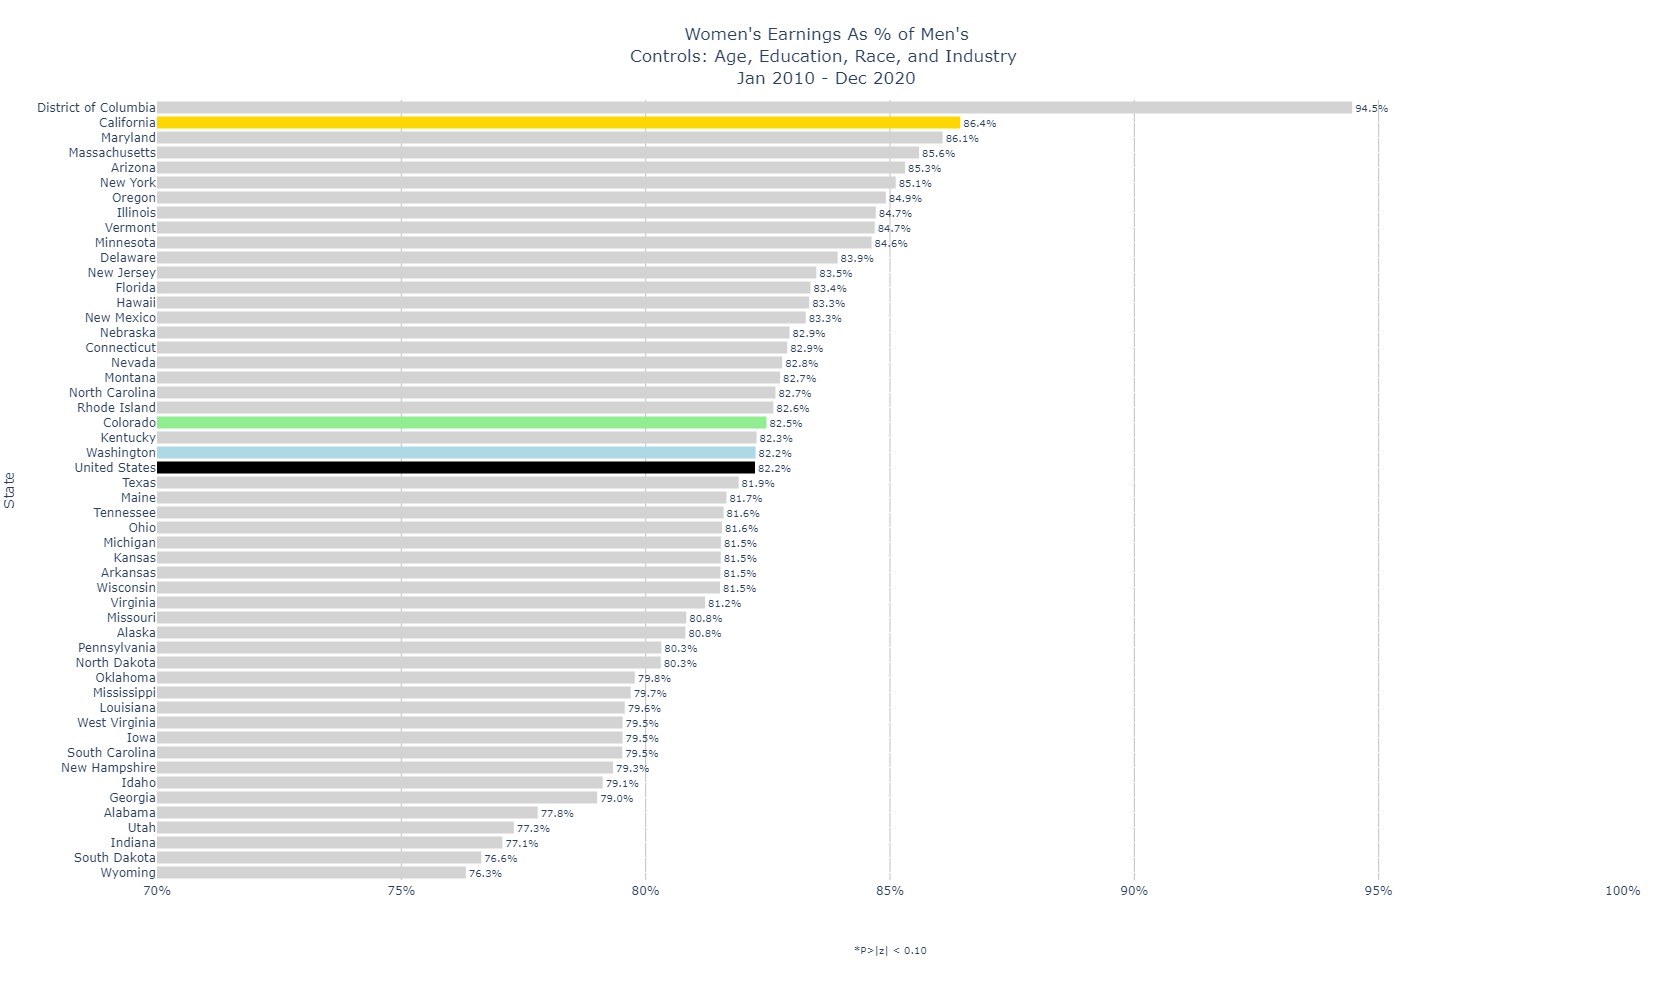

In [72]:
# Pre-EPEWA gap, industry controls

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

wage_gap_ranking = wage_gap_ranking.sort_values(by='Pre_EPEWA_Gap', ascending=True)

state_colors = ['#D3D3D3'] * len(wage_gap_ranking)
for i, state in enumerate(wage_gap_ranking.index):
    if 'Colorado' in state:
        state_colors[i] = 'lightgreen'
    elif 'California' in state:
        state_colors[i] = 'gold'
    elif 'Washington' in state:
        state_colors[i] = 'lightblue'
    elif 'United States' in state:
        state_colors[i] = 'black'

wage_gap_ranking.index = [
    f"{state}*" if pval > 0.10 else state 
    for state, pval in zip(wage_gap_ranking.index, wage_gap_ranking['female_pval'])
]

wage_gap_ranking = wage_gap_ranking.sort_values(by='Pre_EPEWA_Gap', ascending=True)

percentage_labels = wage_gap_ranking['Pre_EPEWA_Gap'].map(lambda x: '{:,.1f}%'.format(x * 100)).values

fig = go.Figure(go.Bar(
    x=wage_gap_ranking['Pre_EPEWA_Gap'],
    y=wage_gap_ranking.index,
    orientation='h',
    marker=dict(color=state_colors),
    text=percentage_labels,
    textposition='outside'
))

fig.update_layout(
    title={
        'text': "Women's Earnings As % of Men's<br>Controls: Age, Education, Race, and Industry <br>Jan 2010 - Dec 2020",
        'y': 0.96,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="State",
    xaxis=dict(
        showgrid=True,
        showline=True,
        gridcolor='grey',
        gridwidth=0.5,
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='grey',
        range=[0.7, 1],
        tickformat='.0%',
    ),
    yaxis=dict(
        showgrid=True,
        showline=False
    ),
    bargap=0.2,
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=20, r=20, t=100, b=120),
    annotations=[
        dict(
             text="*P>|z| < 0.10",
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            showarrow=False,
            font=dict(size=10),
            align='center'
        )
    ]
)

fig.update_traces(marker_line_width=0)

fig.show()

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

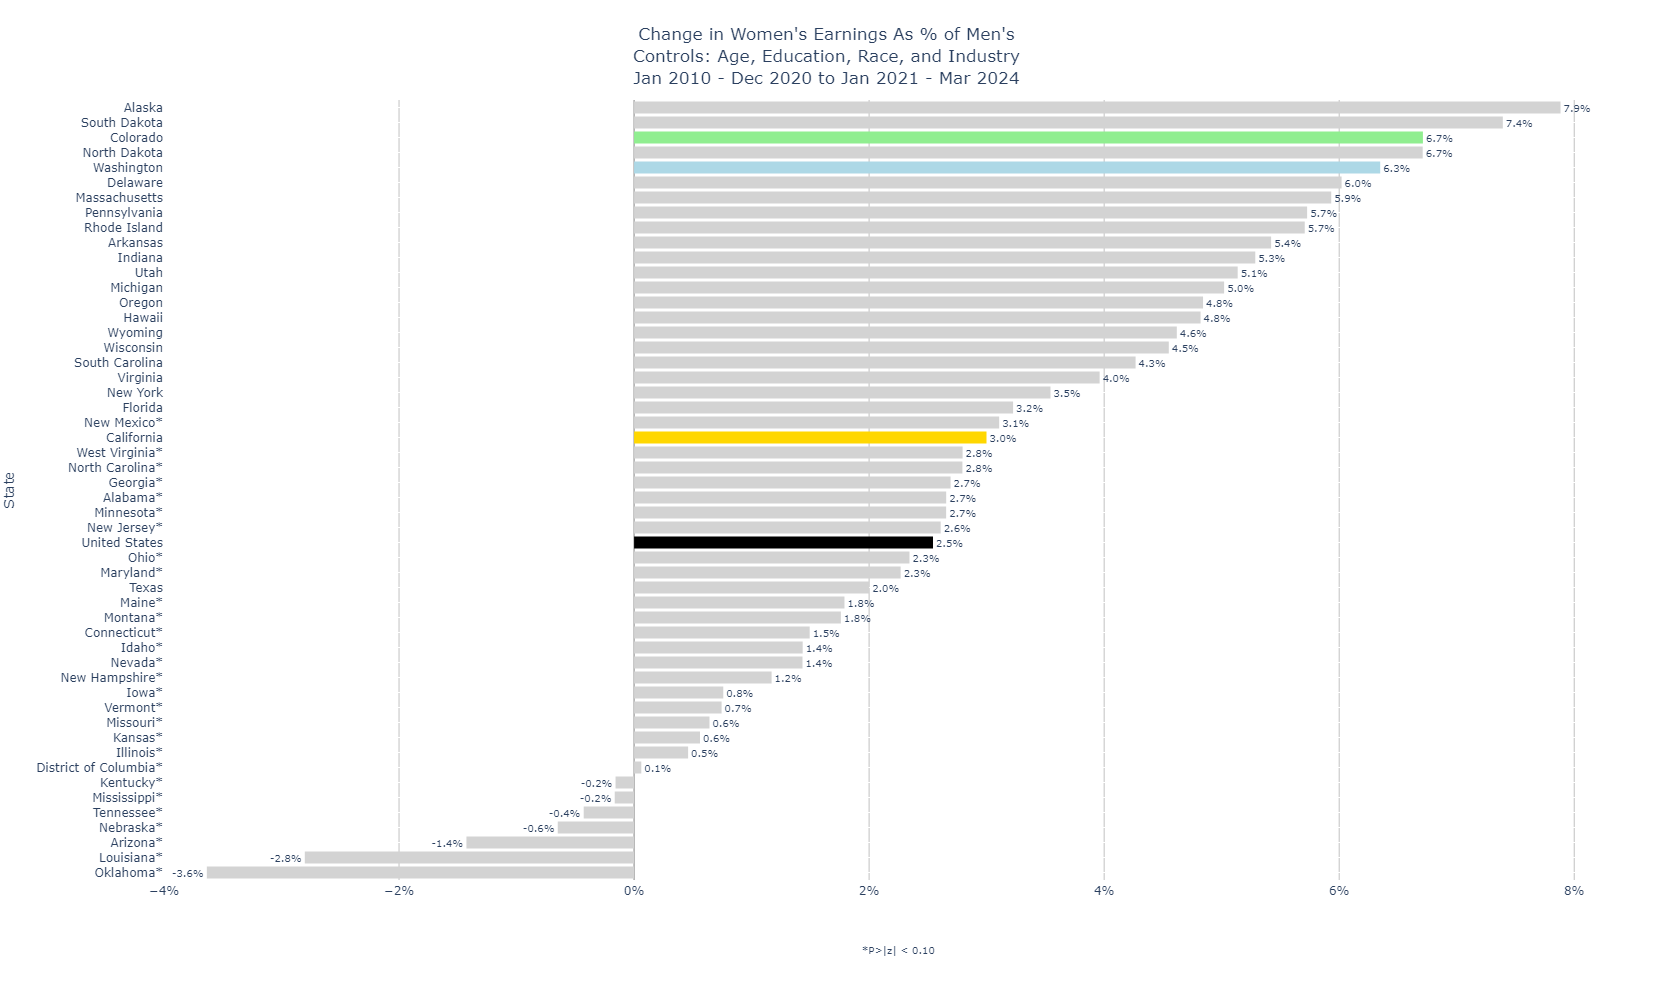

In [73]:
# Change Pre vs. Post EPEWA Gap, Industry Controls

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

wage_gap_ranking = wage_gap_ranking.sort_values(by='interaction_coef', ascending=True)

state_colors = ['#D3D3D3'] * len(wage_gap_ranking)
for i, state in enumerate(wage_gap_ranking.index):
    if 'Colorado' in state:
        state_colors[i] = 'lightgreen'
    elif 'California' in state:
        state_colors[i] = 'gold'
    elif 'Washington' in state:
        state_colors[i] = 'lightblue'
    elif 'United States' in state:
        state_colors[i] = 'black'

wage_gap_ranking.index = [
    f"{state}*" if pval > 0.10 else state 
    for state, pval in zip(wage_gap_ranking.index, wage_gap_ranking['interaction_pval'])
]

wage_gap_ranking = wage_gap_ranking.sort_values(by='interaction_coef', ascending=True)

percentage_labels = wage_gap_ranking['interaction_coef'].map(lambda x: '{:,.1f}%'.format(x * 100)).values

fig = go.Figure(go.Bar(
    x=wage_gap_ranking['interaction_coef'],
    y=wage_gap_ranking.index,
    orientation='h',
    marker=dict(color=state_colors),
    text=percentage_labels,
    textposition='outside'
))

fig.update_layout(
    title={
        'text': "Change in Women's Earnings As % of Men's<br>Controls: Age, Education, Race, and Industry<br>Jan 2010 - Dec 2020 to Jan 2021 - Mar 2024",
        'y': 0.96,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="State",
    xaxis=dict(
        showgrid=True,
        showline=True,
        gridcolor='grey',
        gridwidth=0.5,
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='grey',
        range=[-0.04, .085],
        tickformat='.0%',
    ),
    yaxis=dict(
        showgrid=True,
        showline=False
    ),
    bargap=0.2,
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=20, r=20, t=100, b=120),
    annotations=[
        dict(
             text="*P>|z| < 0.10",
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            showarrow=False,
            font=dict(size=10),
            align='center'
        )
    ]
)

fig.update_traces(marker_line_width=0)

fig.show()

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

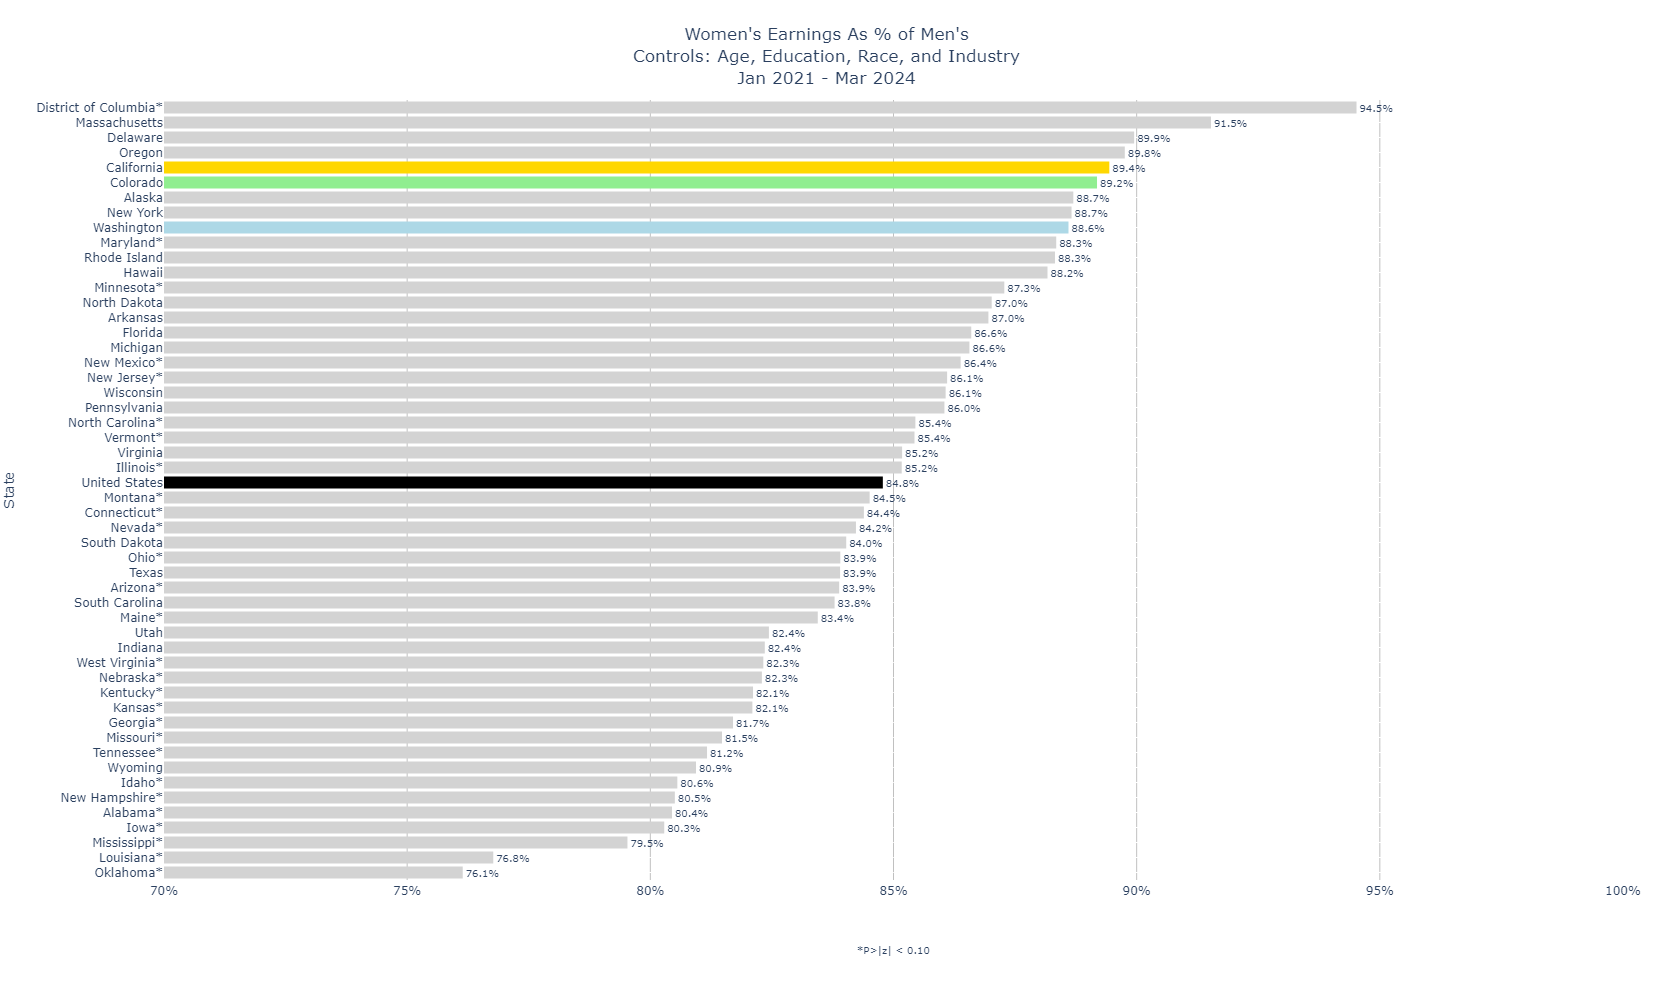

In [74]:
# Post-EPEWA Gap, Industry Controls

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

wage_gap_ranking = wage_gap_ranking.sort_values(by='Post_EPEWA_Gap', ascending=True)

state_colors = ['#D3D3D3'] * len(wage_gap_ranking)
for i, state in enumerate(wage_gap_ranking.index):
    if 'Colorado' in state:
        state_colors[i] = 'lightgreen'
    elif 'California' in state:
        state_colors[i] = 'gold'
    elif 'Washington' in state:
        state_colors[i] = 'lightblue'
    elif 'United States' in state:
        state_colors[i] = 'black'

wage_gap_ranking.index = [
    f"{state}*" if pval > 0.10 else state 
    for state, pval in zip(wage_gap_ranking.index, wage_gap_ranking['interaction_pval'])
]

wage_gap_ranking = wage_gap_ranking.sort_values(by='Post_EPEWA_Gap', ascending=True)

percentage_labels = wage_gap_ranking['Post_EPEWA_Gap'].map(lambda x: '{:,.1f}%'.format(x * 100)).values

fig = go.Figure(go.Bar(
    x=wage_gap_ranking['Post_EPEWA_Gap'],
    y=wage_gap_ranking.index,
    orientation='h',
    marker=dict(color=state_colors),
    text=percentage_labels,
    textposition='outside'
))

fig.update_layout(
    title={
        'text': "Women's Earnings As % of Men's<br>Controls: Age, Education, Race, and Industry<br>Jan 2021 - Mar 2024",
        'y': 0.96,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="State",
    xaxis=dict(
        showgrid=True,
        showline=True,
        gridcolor='grey',
        gridwidth=0.5,
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='grey',
        range=[0.7, 1],
        tickformat='.0%',
    ),
    yaxis=dict(
        showgrid=True,
        showline=False
    ),
    bargap=0.2,
    plot_bgcolor='white',
    height=1000,
    margin=dict(l=20, r=20, t=100, b=120),
    annotations=[
        dict(
             text="*P>|z| < 0.10",
            x=0.5,
            y=-0.1,
            xref='paper',
            yref='paper',
            showarrow=False,
            font=dict(size=10),
            align='center'
        )
    ]
)

fig.update_traces(marker_line_width=0)

fig.show()

wage_gap_ranking.index = wage_gap_ranking.index.str.replace(r"\*", "", regex=True)

# Section 6: Supplementary Analysis and Robustness Checks

This section of code seeks to analyze some supplementary considerations. These include:

1. Is the reduction in the gender wage gap in Colorado being driven by women's wages going up, or men's wages going down? This is accomplished by repeating the primary regression but with men only in the sample. This compares Colorado men's wages to the rest of the men in the United States.
2. Is the reduction within Colorado determined by a specific industry? This was evaluated by splitting the Colorado subsample into industry-specific samples and running the regression without industry controls. The analysis runs into significant issues due to small sample size
3. Is the reduction in the gender wage gap in Colorado driven by urban or rural parts of the state? Again, this runs into significant issues due to small sample size.
4. What is the increase in women's wages relative to men's in terms of dollars (not percentage points)?

In [50]:
# Define the formula for the regression model without the 'female' variable

formula = 'log_earnyear ~ C(epewa) + C(co) + C(epewa):C(co) + C(age) + C(ind_cat20_label) + C(race_cat) + C(educ)'

# Filter the DataFrame for males only

male_subset = ipums_df[ipums_df['female'] == 0]

# Run formula above

model = smf.ols(formula, data=male_subset).fit(cov_type='HC3')
        
print('Regression Measuring Change in Colorado Male Wages Relative to US, Before and After EPEWA')
display(model.summary())

Regression Measuring Change in Colorado Male Wages Relative to US, Before and After EPEWA


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     2059.
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:07:10   Log-Likelihood:            -1.7152e+05
No. Observations:              303994   AIC:                         3.432e+05
Df Residuals:                  303919   BIC:                         3.440e+05
Df Model:                          74                                         
Covariance Type:                  HC3                                         
===================================================================================================================================================================
                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          10.0076      0.010   1032.063      0.000       9.989      10.027
C(epewa)[T.1]                                                                                       0.1888      0.002     97.128      0.000       0.185       0.193
C(co)[T.True]                                                                                       0.0373      0.006      5.946      0.000       0.025       0.050
C(age)[T.Age 25]                                                                                    0.0824      0.006     13.307      0.000       0.070       0.095
C(age)[T.Age 26]                                                                                    0.1201      0.006     19.562      0.000       0.108       0.132
C(age)[T.Age 27]                                                                                    0.1418      0.006     23.230      0.000       0.130       0.154
C(age)[T.Age 28]                                                                                    0.1615      0.006     26.643      0.000       0.150       0.173
C(age)[T.Age 29]                                                                                    0.1848      0.006     30.625      0.000       0.173       0.197
C(age)[T.Age 30]                                                                                    0.1884      0.006     31.466      0.000       0.177       0.200
C(age)[T.Age 31]                                                                                    0.2217      0.006     36.848      0.000       0.210       0.234
C(age)[T.Age 32]                                                                                    0.2339      0.006     39.043      0.000       0.222       0.246
C(age)[T.Age 33]                                                                                    0.2449      0.006     40.228      0.000       0.233       0.257
C(age)[T.Age 34]                                                                                    0.2631      0.006     42.689      0.000       0.251       0.275
C(age)[T.Age 35]                                                                                    0.3098      0.006     50.232      0.000       0.298       0.322
C(age)[T.Age 36]                                                                                    0.3308      0.006     53.538      0.000       0.319       0.343
C(age)[T.Age 37]                                                                                    0.3394      0.006     54.455   

There appears to be no statistically significant drop in Colorado men's wages relative to the rest of the United States. While it is statistically insignicant, it appears Colorado men's wages may be increasing relative to the rest of the United States.

In [51]:
# The following code analyzes the effect in Colorado by industry

# Get unique industry categories

industry_categories = ipums_df['ind_cat20'].unique()

# Initialize a dictionary to hold the DataFrames for each industry category

industry_subsets = {}

# Loop through each industry category to create a subset DataFrame when co=1

for industry in industry_categories:
    
    # Subset for each industry where co is 1

    subset = ipums_df[(ipums_df['co'] == 1) & (ipums_df['ind_cat20'] == industry)]
    
    # Add the subset DataFrame to the dictionary with the industry category as the key
    
    industry_subsets[industry] = subset

In [52]:
# Define formula for Colorado within-industry gender wage gap change

formula = 'log_earnyear ~ C(epewa) + C(female) + C(female):C(epewa) + C(age) + C(race_cat) + C(educ)'

regression_results = []

# Loop through each industry category to create a subset DataFrame when co=1 and run regression

for industry in industry_categories:

    # Find the corresponding label for the current industry category
    
    industry_label = ipums_df[ipums_df['ind_cat20'] == industry]['ind_cat20_label'].iloc[0]
    
    # Subset for each industry where co is 1
    
    subset = ipums_df[(ipums_df['co'] == 1) & (ipums_df['ind_cat20'] == industry)]
    
    # Check if the subset is not empty
    
    if not subset.empty:
        
        # Attempt to run the regression on the subset
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", RuntimeWarning)  # Convert RuntimeWarnings to errors
                model = smf.ols(formula, data=subset).fit(cov_type='HC3')
                
                female_coef = model.params.get('C(female)[T.1]')
                female_pval = model.pvalues.get('C(female)[T.1]')
                interaction_coef = model.params.get('C(female)[T.1]:C(epewa)[T.1]')
                interaction_pval = model.pvalues.get('C(female)[T.1]:C(epewa)[T.1]')
                
                regression_results.append({
                    'Industry Label': industry_label,
                    'Female Coefficient': female_coef,
                    'Female P-Value': female_pval,
                    'Interaction Coefficient': interaction_coef,
                    'Interaction P-Value': interaction_pval
                })
        
        except RuntimeWarning:
            print(f"Divide by zero error encountered for {industry_label}. Storing 'Insufficient sample'.")
            
            # Store a placeholder indicating insufficient sample for this industry.
            # This occurs through a combination of sample size and over specification.
            
            regression_results.append({
                'Industry Label': industry_label,
                'Female Coefficient': 'Insufficient sample',
                'Female P-Value': 'Insufficient sample',
                'Interaction Coefficient': 'Insufficient sample',
                'Interaction P-Value': 'Insufficient sample'
            })
        except Exception as e:
            print(f"Skipped regression for {industry_label} due to an error: {e}")

Divide by zero error encountered for Educational Services:. Storing 'Insufficient sample'.
Divide by zero error encountered for Information:. Storing 'Insufficient sample'.
Divide by zero error encountered for Administrative and Support and Waste Management and Remediation Services:. Storing 'Insufficient sample'.
Divide by zero error encountered for Transportation and Warehousing:. Storing 'Insufficient sample'.
Divide by zero error encountered for Agriculture, Forestry, Fishing and Hunting:. Storing 'Insufficient sample'.


In [53]:
# Create a DataFrame from the compiled regression results

co_industry_results = pd.DataFrame(regression_results)

display(co_industry_results)

Industry Label   Female Coefficient  \
0   Professional, Scientific, and Technical Services:              -0.2915   
1                              Public Administration:              -0.1364   
2                              Finance and Insurance:              -0.1830   
3                    Accommodation and Food Services:              -0.0494   
4                                    Wholesale Trade:              -0.1567   
5                                                 N/A              -0.0436   
6                               Educational Services:  Insufficient sample   
7      Other Services (Except Public Administration):              -0.2724   
8                                        Information:  Insufficient sample   
9   Administrative and Support and Waste Managemen...  Insufficient sample   
10                    Transportation and Warehousing:  Insufficient sample   
11                                      Retail Trade:              -0.1924   
12                 Health Care and Social Assistance:              -0.1278   
13                                     Manufacturing:              -0.2274   
14                                         Utilities:              -0.2437   
15                Real Estate and Rental and Leasing:              -0.0973   
16        Agriculture, Forestry, Fishing and Hunting:  Insufficient sample   
17     Mining, Quarrying, and Oil and Gas Extraction:              -0.2488   
18               Arts, Entertainment, and Recreation:              -0.1103   
19           Management of Companies and Enterprises:               2.3768   
20                                      Construction:              -0.2463   

         Female P-Value Interaction Coefficient  Interaction P-Value  
0                0.0000                  0.2519               0.0003  
1                0.0004                 -0.1063               0.2590  
2                0.0002                  0.1006               0.3270  
3                0.2980                  0.0671               0.6794  
4                0.0332                 -0.0633               0.7985  
5                0.4921                    None                 None  
6   Insufficient sample     Insufficient sample  Insufficient sample  
7                0.0000                  0.1109               0.5654  
8   Insufficient sample     Insufficient sample  Insufficient sample  
9   Insufficient sample     Insufficient sample  Insufficient sample  
10  Insufficient sample     Insufficient sample  Insufficient sample  
11               0.0000                  0.1111               0.1474  
12               0.0001                  0.0188               0.8223  
13               0.0000                  0.1576               0.1550  
14               0.0600                 -0.0150               0.9657  
15               0.2981                  0.2263               0.3467  
16  Insufficient sample     Insufficient sample  Insufficient sample  
17               0.1773                  0.1971               0.6252  
18               0.2643                  0.2216               0.3508  
19               0.9234                    None                 None  
20               0.0005                  0.0660               0.5797

In [54]:
# Convert coefficients and p-values to numeric, errors='coerce' will set 'Insufficient sample' to NaN

co_industry_results['Female Coefficient'] = pd.to_numeric(co_industry_results['Female Coefficient'], errors='coerce')
co_industry_results['Female P-Value'] = pd.to_numeric(co_industry_results['Female P-Value'], errors='coerce')
co_industry_results['Interaction Coefficient'] = pd.to_numeric(co_industry_results['Interaction Coefficient'], errors='coerce')
co_industry_results['Interaction P-Value'] = pd.to_numeric(co_industry_results['Interaction P-Value'], errors='coerce')

# Drop all rows with NaN values which result from 'Insufficient sample'

co_industry_results.dropna(inplace=True)

# Create the "Pre-EPEWA Wage Gap" column

co_industry_results['Pre-EPEWA Wage Gap'] = 1 + co_industry_results['Female Coefficient']

# Create the "Post-EPEWA Wage Gap" column

co_industry_results['Post-EPEWA Wage Gap'] = co_industry_results['Pre-EPEWA Wage Gap'] + co_industry_results['Interaction Coefficient']

# Display the modified DataFrame

display(co_industry_results)

Industry Label  Female Coefficient  \
0   Professional, Scientific, and Technical Services:             -0.2915   
1                              Public Administration:             -0.1364   
2                              Finance and Insurance:             -0.1830   
3                    Accommodation and Food Services:             -0.0494   
4                                    Wholesale Trade:             -0.1567   
7      Other Services (Except Public Administration):             -0.2724   
11                                      Retail Trade:             -0.1924   
12                 Health Care and Social Assistance:             -0.1278   
13                                     Manufacturing:             -0.2274   
14                                         Utilities:             -0.2437   
15                Real Estate and Rental and Leasing:             -0.0973   
17     Mining, Quarrying, and Oil and Gas Extraction:             -0.2488   
18               Arts, Entertainment, and Recreation:             -0.1103   
20                                      Construction:             -0.2463   

    Female P-Value  Interaction Coefficient  Interaction P-Value  \
0           0.0000                   0.2519               0.0003   
1           0.0004                  -0.1063               0.2590   
2           0.0002                   0.1006               0.3270   
3           0.2980                   0.0671               0.6794   
4           0.0332                  -0.0633               0.7985   
7           0.0000                   0.1109               0.5654   
11          0.0000                   0.1111               0.1474   
12          0.0001                   0.0188               0.8223   
13          0.0000                   0.1576               0.1550   
14          0.0600                  -0.0150               0.9657   
15          0.2981                   0.2263               0.3467   
17          0.1773                   0.1971               0.6252   
18          0.2643                   0.2216               0.3508   
20          0.0005                   0.0660               0.5797   

    Pre-EPEWA Wage Gap  Post-EPEWA Wage Gap  
0               0.7085               0.9603  
1               0.8636               0.7573  
2               0.8170               0.9176  
3               0.9506               1.0177  
4               0.8433               0.7801  
7               0.7276               0.8385  
11              0.8076               0.9187  
12              0.8722               0.8911  
13              0.7726               0.9302  
14              0.7563               0.7413  
15              0.9027               1.1290  
17              0.7512               0.9483  
18              0.8897               1.1113  
20              0.7537               0.8197

In [55]:
# Add an asterisk to industry names where interaction p-value is greater than .10

co_industry_results['Industry Label Modified'] = co_industry_results.apply(
    lambda row: row['Industry Label'] + '*' if row['Interaction P-Value'] > 0.10 else row['Industry Label'],
    axis=1)

# Display the DataFrame with modified industry labels

display(co_industry_results.drop(columns=['Industry Label']) 
         .rename(columns={'Industry Label Modified': 'Industry Label'}))

Female Coefficient  Female P-Value  Interaction Coefficient  \
0              -0.2915          0.0000                   0.2519   
1              -0.1364          0.0004                  -0.1063   
2              -0.1830          0.0002                   0.1006   
3              -0.0494          0.2980                   0.0671   
4              -0.1567          0.0332                  -0.0633   
7              -0.2724          0.0000                   0.1109   
11             -0.1924          0.0000                   0.1111   
12             -0.1278          0.0001                   0.0188   
13             -0.2274          0.0000                   0.1576   
14             -0.2437          0.0600                  -0.0150   
15             -0.0973          0.2981                   0.2263   
17             -0.2488          0.1773                   0.1971   
18             -0.1103          0.2643                   0.2216   
20             -0.2463          0.0005                   0.0660   

    Interaction P-Value  Pre-EPEWA Wage Gap  Post-EPEWA Wage Gap  \
0                0.0003              0.7085               0.9603   
1                0.2590              0.8636               0.7573   
2                0.3270              0.8170               0.9176   
3                0.6794              0.9506               1.0177   
4                0.7985              0.8433               0.7801   
7                0.5654              0.7276               0.8385   
11               0.1474              0.8076               0.9187   
12               0.8223              0.8722               0.8911   
13               0.1550              0.7726               0.9302   
14               0.9657              0.7563               0.7413   
15               0.3467              0.9027               1.1290   
17               0.6252              0.7512               0.9483   
18               0.3508              0.8897               1.1113   
20               0.5797              0.7537               0.8197   

                                       Industry Label  
0   Professional, Scientific, and Technical Services:  
1                             Public Administration:*  
2                             Finance and Insurance:*  
3                   Accommodation and Food Services:*  
4                                   Wholesale Trade:*  
7     Other Services (Except Public Administration):*  
11                                     Retail Trade:*  
12                Health Care and Social Assistance:*  
13                                    Manufacturing:*  
14                                        Utilities:*  
15               Real Estate and Rental and Leasing:*  
17    Mining, Quarrying, and Oil and Gas Extraction:*  
18              Arts, Entertainment, and Recreation:*  
20                                     Construction:*

Professional, Scientific, and Technical Services is the only industry to see a statistically significant drop.
It is a highly significant drop, almost eliminating the gender wage gap.
This seems to be driving the drop in the gender wage gap, though other industries may also be contributing.
It is difficult to tell to what magnitude other industries are contributing.

In [56]:
# According to the Colorado demographer, the 'Front Range' urban corridor of Colorado ranges from 70-90% of the state
# https://storymaps.arcgis.com/stories/f622f3746d7649749b103e1e2b018a35
# Define the list of METFIP codes for urban areas within Colorado
# These urban areas are associated with Fort Collins, Boulder, Denver, Colorado Springs, Pueblo, and Greeley
# https://cps.ipums.org/cps/codes/metfips_2014onward_codes.shtml

urban_metro_fips = [19740, 17820, 22660, 24540, 39380, 14500]

# Create 'urban_co' binary variable, which is 1 if METFIP is in the list and co is 1

ipums_df['urban_co'] = ((ipums_df['METFIPS'].isin(urban_metro_fips)) & (ipums_df['co'] == 1)).astype(int)

# Create 'rural_co' binary variable, which is 1 if 'urban_co' is 0 and co is 1

ipums_df['rural_co'] = ((ipums_df['urban_co'] == 0) & (ipums_df['co'] == 1)).astype(int)

In [57]:
# Define the formula for the regression model without the 'female' variable
# Because the sample is so small, controls were dropped to take the simplest measure possible

formula = 'log_earnyear ~ C(epewa) + C(female) + C(epewa):C(female)'

# Filter the DataFrame for urban only

urban_co_subset = ipums_df[ipums_df['urban_co'] == 1]

model = smf.ols(formula, data=urban_co_subset).fit(cov_type='HC3')

print('Simple Gender Wage Gap Model Results for Urban Colorado, No Controls')
display(model.summary())

Simple Gender Wage Gap Model Results for Urban Colorado, No Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     211.8
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          1.93e-132
Time:                        13:07:15   Log-Likelihood:                -6065.1
No. Observations:                8423   AIC:                         1.214e+04
Df Residuals:                    8419   BIC:                         1.217e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       10.8770      0.008   1337.955      0.000      10.861      10.893
C(epewa)[T.1]                    0.2476      0.019     12.842      0.000       0.210       0.285
C(female)[T.1]                  -0.1593      0.012    -13.389      0.000      -0.183      -0.136
C(epewa)[T.1]:C(female)[T.1]     0.1062      0.028      3.802      0.000       0.051       0.161
==============================================================================
Omnibus:                      474.141   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.843
Skew:                           0.041   Prob(JB):                     5.38e-40
Kurtosis:                       2.287   Cond. No.                         7.44
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [58]:
formula = 'log_earnyear ~ C(epewa) + C(female) + C(epewa):C(female)'

# Filter the DataFrame for rural only

rural_co_subset = ipums_df[ipums_df['rural_co'] == 1]

model = smf.ols(formula, data=rural_co_subset).fit(cov_type='HC3')

print('Simple Gender Wage Gap Model Results for Rural Colorado, No Controls')
display(model.summary())

Simple Gender Wage Gap Model Results for Rural Colorado, No Controls


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_earnyear   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     33.76
Date:                Mon, 22 Apr 2024   Prob (F-statistic):           6.25e-21
Time:                        13:07:15   Log-Likelihood:                -794.42
No. Observations:                1182   AIC:                             1597.
Df Residuals:                    1178   BIC:                             1617.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       10.7798      0.021    524.258      0.000      10.740      10.820
C(epewa)[T.1]                    0.2007      0.048      4.140      0.000       0.106       0.296
C(female)[T.1]                  -0.2172      0.030     -7.127      0.000      -0.277      -0.157
C(epewa)[T.1]:C(female)[T.1]     0.0949      0.071      1.339      0.180      -0.044       0.234
==============================================================================
Omnibus:                       39.683   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.519
Skew:                           0.244   Prob(JB):                     1.74e-06
Kurtosis:                       2.453   Cond. No.                         7.22
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

While the P-value for the rural Colorado dataset is too weak to reach conclusions, the magnitude of the interaction coefficient for the urban and rural samples are consistent at approximately 10 percentage points. There does not appear to be a large difference between the rural and urban reduction in the gender wage gap using the simplest measure.

In [59]:
# The following code measures the dollar value of the primary finding in Colorado vs. non-pay transparent states
# Industry controls

formula = 'earnyear ~ C(female) + C(epewa) + C(female):C(epewa) + C(age) + C(ind_cat20) + C(race_cat) + C(educ)'

comp_cat4_categories = ipums_df['comp_cat4'].unique()

for category in comp_cat4_categories:
    subset = ipums_df[ipums_df['comp_cat4'] == category]
    
    model = smf.ols(formula, data=subset).fit(cov_type='HC3')
    print(f"Industry Controlled Regression for comp_cat4 category {category}:")
    display(model.summary())
    print("\n\n")

Industry Controlled Regression for comp_cat4 category Rest of US:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     2883.
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:07:35   Log-Likelihood:            -5.6384e+06
No. Observations:              490706   AIC:                         1.128e+07
Df Residuals:                  490631   BIC:                         1.128e+07
Df Model:                          74                                         
Covariance Type:                  HC3                                         
=============================================================================================================================================================
                                                                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  1.966e+04    385.603     50.993      0.000    1.89e+04    2.04e+04
C(female)[T.1]                                                                            -9451.6824     79.453   -118.960      0.000   -9607.407   -9295.958
C(epewa)[T.1]                                                                              9771.2702    131.198     74.477      0.000    9514.127       1e+04
C(age)[T.Age 25]                                                                           3449.1537    221.933     15.541      0.000    3014.173    3884.134
C(age)[T.Age 26]                                                                           4618.9128    221.556     20.848      0.000    4184.671    5053.155
C(age)[T.Age 27]                                                                           5915.3361    224.093     26.397      0.000    5476.122    6354.550
C(age)[T.Age 28]                                                                           6538.0546    226.220     28.901      0.000    6094.672    6981.437
C(age)[T.Age 29]                                                                           7604.7166    225.569     33.713      0.000    7162.609    8046.824
C(age)[T.Age 30]                                                                           8023.4577    227.107     35.329      0.000    7578.336    8468.579
C(age)[T.Age 31]                                                                           9651.8674    231.640     41.667      0.000    9197.861    1.01e+04
C(age)[T.Age 32]                                                                           1.037e+04    232.159     44.659      0.000    9913.090    1.08e+04
C(age)[T.Age 33]                                                                           1.086e+04    236.366     45.938      0.000    1.04e+04    1.13e+04
C(age)[T.Age 34]                                                                           1.145e+04    238.192     48.091      0.000     1.1e+04    1.19e+04
C(age)[T.Age 35]                                                                            1.43e+04    245.349     58.300      0.000    1.38e+04    1.48e+04
C(age)[T.Age 36]                                                                           1.519e+04    247.151     61.466      0.000    1.47e+04    1.57e+04
C(age)[T.Age 37]                                                                           1.547e+04    250.678     61.716      0.000     1.5e+04     1.6e+04
C(age)[T.Age 38]                                                                 




Industry Controlled Regression for comp_cat4 category California:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     341.9
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:07:37   Log-Likelihood:            -5.0942e+05
No. Observations:               44140   AIC:                         1.019e+06
Df Residuals:                   44065   BIC:                         1.020e+06
Df Model:                          74                                         
Covariance Type:                  HC3                                         
=============================================================================================================================================================
                                                                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  1.982e+04   1027.990     19.278      0.000    1.78e+04    2.18e+04
C(female)[T.1]                                                                            -7958.2554    276.874    -28.743      0.000   -8500.919   -7415.592
C(epewa)[T.1]                                                                              9981.1792    436.365     22.873      0.000    9125.920    1.08e+04
C(age)[T.Age 25]                                                                           4585.3208    828.596      5.534      0.000    2961.302    6209.339
C(age)[T.Age 26]                                                                           6107.5358    853.024      7.160      0.000    4435.640    7779.432
C(age)[T.Age 27]                                                                           6440.0807    833.219      7.729      0.000    4807.001    8073.161
C(age)[T.Age 28]                                                                           7966.6554    836.868      9.520      0.000    6326.425    9606.886
C(age)[T.Age 29]                                                                           8889.6138    836.514     10.627      0.000    7250.077    1.05e+04
C(age)[T.Age 30]                                                                           8960.2568    847.289     10.575      0.000    7299.602    1.06e+04
C(age)[T.Age 31]                                                                           1.063e+04    837.391     12.689      0.000    8984.063    1.23e+04
C(age)[T.Age 32]                                                                           1.218e+04    868.991     14.020      0.000    1.05e+04    1.39e+04
C(age)[T.Age 33]                                                                           1.131e+04    869.906     13.000      0.000    9603.453     1.3e+04
C(age)[T.Age 34]                                                                            1.34e+04    899.526     14.897      0.000    1.16e+04    1.52e+04
C(age)[T.Age 35]                                                                           1.544e+04    886.070     17.423      0.000    1.37e+04    1.72e+04
C(age)[T.Age 36]                                                                           1.761e+04    895.177     19.674      0.000    1.59e+04    1.94e+04
C(age)[T.Age 37]                                                                           1.859e+04    899.237     20.670      0.000    1.68e+04    2.03e+04
C(age)[T.Age 38]                                                                 




Industry Controlled Regression for comp_cat4 category Washington:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     67.21
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:07:38   Log-Likelihood:            -1.1001e+05
No. Observations:                9537   AIC:                         2.202e+05
Df Residuals:                    9462   BIC:                         2.207e+05
Df Model:                          74                                         
Covariance Type:                  HC3                                         
=============================================================================================================================================================
                                                                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  2.396e+04   2898.307      8.265      0.000    1.83e+04    2.96e+04
C(female)[T.1]                                                                            -1.031e+04    603.988    -17.073      0.000   -1.15e+04   -9128.345
C(epewa)[T.1]                                                                              1.179e+04    919.550     12.825      0.000    9990.912    1.36e+04
C(age)[T.Age 25]                                                                           3405.0816   1629.218      2.090      0.037     211.873    6598.291
C(age)[T.Age 26]                                                                           6575.4675   1768.635      3.718      0.000    3109.007       1e+04
C(age)[T.Age 27]                                                                           8996.0226   1695.276      5.307      0.000    5673.343    1.23e+04
C(age)[T.Age 28]                                                                           9363.3965   1700.838      5.505      0.000    6029.815    1.27e+04
C(age)[T.Age 29]                                                                           8806.3915   1765.236      4.989      0.000    5346.593    1.23e+04
C(age)[T.Age 30]                                                                           1.098e+04   1710.500      6.421      0.000    7630.537    1.43e+04
C(age)[T.Age 31]                                                                            1.47e+04   1754.475      8.377      0.000    1.13e+04    1.81e+04
C(age)[T.Age 32]                                                                           1.301e+04   1716.963      7.579      0.000    9647.669    1.64e+04
C(age)[T.Age 33]                                                                           1.408e+04   1776.130      7.926      0.000    1.06e+04    1.76e+04
C(age)[T.Age 34]                                                                           1.621e+04   1752.851      9.246      0.000    1.28e+04    1.96e+04
C(age)[T.Age 35]                                                                           1.717e+04   1778.273      9.655      0.000    1.37e+04    2.07e+04
C(age)[T.Age 36]                                                                           1.747e+04   1798.456      9.712      0.000    1.39e+04     2.1e+04
C(age)[T.Age 37]                                                                           1.738e+04   1794.007      9.690      0.000    1.39e+04    2.09e+04
C(age)[T.Age 38]                                                                 




Industry Controlled Regression for comp_cat4 category Colorado:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     67.76
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:07:38   Log-Likelihood:            -1.1074e+05
No. Observations:                9605   AIC:                         2.216e+05
Df Residuals:                    9530   BIC:                         2.222e+05
Df Model:                          74                                         
Covariance Type:                  HC3                                         
=============================================================================================================================================================
                                                                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                  1.784e+04   3205.176      5.566      0.000    1.16e+04    2.41e+04
C(female)[T.1]                                                                            -1.005e+04    584.883    -17.181      0.000   -1.12e+04   -8902.317
C(epewa)[T.1]                                                                              1.212e+04   1108.181     10.934      0.000    9945.404    1.43e+04
C(age)[T.Age 25]                                                                           6482.0620   1696.713      3.820      0.000    3156.565    9807.559
C(age)[T.Age 26]                                                                           4025.0428   1547.686      2.601      0.009     991.634    7058.452
C(age)[T.Age 27]                                                                           6561.6561   1649.310      3.978      0.000    3329.068    9794.244
C(age)[T.Age 28]                                                                           1.087e+04   1680.586      6.466      0.000    7572.307    1.42e+04
C(age)[T.Age 29]                                                                           9175.6858   1557.566      5.891      0.000    6122.912    1.22e+04
C(age)[T.Age 30]                                                                           9616.3884   1636.647      5.876      0.000    6408.619    1.28e+04
C(age)[T.Age 31]                                                                           1.041e+04   1623.817      6.408      0.000    7223.399    1.36e+04
C(age)[T.Age 32]                                                                           1.227e+04   1645.565      7.454      0.000    9040.565    1.55e+04
C(age)[T.Age 33]                                                                           1.404e+04   1610.964      8.718      0.000    1.09e+04    1.72e+04
C(age)[T.Age 34]                                                                           1.337e+04   1711.880      7.812      0.000       1e+04    1.67e+04
C(age)[T.Age 35]                                                                           1.603e+04   1754.467      9.139      0.000    1.26e+04    1.95e+04
C(age)[T.Age 36]                                                                           2.235e+04   1923.989     11.619      0.000    1.86e+04    2.61e+04
C(age)[T.Age 37]                                                                           1.907e+04   1808.370     10.546      0.000    1.55e+04    2.26e+04
C(age)[T.Age 38]                                                                 

The reduction in the gender wage gap with industry controls in Colorado is approximately $3,020 per year and is statistically significant at the 10 percent signficance level.

In [60]:
# The following code measures the dollar value of the primary finding in Colorado vs. non-pay transparent states
# No controls

formula = 'earnyear ~ C(female) + C(epewa) + C(female):C(epewa) + C(age) + C(race_cat) + C(educ)'

comp_cat4_categories = ipums_df['comp_cat4'].unique()

for category in comp_cat4_categories:
    subset = ipums_df[ipums_df['comp_cat4'] == category]
    
    model = smf.ols(formula, data=subset).fit(cov_type='HC3')
    print(f"No Industry Controlled Regression for comp_cat4 category {category}:")
    display(model.summary())
    print("\n\n")

No Industry Controlled Regression for comp_cat4 category Rest of US:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     3454.
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:07:52   Log-Likelihood:            -5.6477e+06
No. Observations:              490706   AIC:                         1.130e+07
Df Residuals:                  490651   BIC:                         1.130e+07
Df Model:                          54                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                               2.647e+04    375.462     70.504      0.000    2.57e+04    2.72e+04
C(female)[T.1]                                         -1.125e+04     75.177   -149.603      0.000   -1.14e+04   -1.11e+04
C(epewa)[T.1]                                           9879.7200    133.342     74.093      0.000    9618.375    1.01e+04
C(age)[T.Age 25]                                        3610.3602    225.937     15.979      0.000    3167.532    4053.189
C(age)[T.Age 26]                                        4866.5552    226.010     21.533      0.000    4423.584    5309.526
C(age)[T.Age 27]                                        6186.4891    228.102     27.122      0.000    5739.417    6633.562
C(age)[T.Age 28]                                        6957.0394    230.991     30.118      0.000    6504.305    7409.774
C(age)[T.Age 29]                                        8127.9154    230.330     35.288      0.000    7676.478    8579.353
C(age)[T.Age 30]                                        8617.3522    231.820     37.173      0.000    8162.994    9071.710
C(age)[T.Age 31]                                        1.027e+04    236.503     43.430      0.000    9807.849    1.07e+04
C(age)[T.Age 32]                                        1.095e+04    236.735     46.238      0.000    1.05e+04    1.14e+04
C(age)[T.Age 33]                                        1.142e+04    241.488     47.275      0.000    1.09e+04    1.19e+04
C(age)[T.Age 34]                                        1.203e+04    243.336     49.437      0.000    1.16e+04    1.25e+04
C(age)[T.Age 35]                                        1.481e+04    250.159     59.201      0.000    1.43e+04    1.53e+04
C(age)[T.Age 36]                                        1.578e+04    251.759     62.685      0.000    1.53e+04    1.63e+04
C(age)[T.Age 37]                                        1.602e+04    255.046     62.801      0.000    1.55e+04    1.65e+04
C(age)[T.Age 38]                                        1.658e+04    257.292     64.450      0.000    1.61e+04    1.71e+04
C(age)[T.Age 39]                                        1.647e+04    254.112     64.822      0.000     1.6e+04     1.7e+04
C(age)[T.Age 40]                                        1.684e+04    254.123     66.258      0.000    1.63e+04    1.73e+04
C(age)[T.Age 41]                                        1.717e+04    256.071     67.048      0.000    1.67e+04    1.77e+04
C(age)[T.Age 42]                                        1.695e+04    255.782     66.279      0.000    1.65e+04    1.75e+04
C(age)[T.Age 43]                                        1.792e+04    261.214     68.609      0.000    1.74e+04    1.84e+04
C(age)[T




No Industry Controlled Regression for comp_cat4 category California:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     420.0
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:07:54   Log-Likelihood:            -5.1022e+05
No. Observations:               44140   AIC:                         1.021e+06
Df Residuals:                   44085   BIC:                         1.021e+06
Df Model:                          54                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                               2.597e+04    965.799     26.890      0.000    2.41e+04    2.79e+04
C(female)[T.1]                                         -8834.7537    268.526    -32.901      0.000   -9361.055   -8308.452
C(epewa)[T.1]                                           9942.5839    441.297     22.530      0.000    9077.658    1.08e+04
C(age)[T.Age 25]                                        4564.6612    840.545      5.431      0.000    2917.222    6212.100
C(age)[T.Age 26]                                        6245.0299    868.597      7.190      0.000    4542.612    7947.448
C(age)[T.Age 27]                                        6659.0764    844.162      7.888      0.000    5004.549    8313.604
C(age)[T.Age 28]                                        8209.6416    849.312      9.666      0.000    6545.021    9874.262
C(age)[T.Age 29]                                        9493.4590    850.824     11.158      0.000    7825.874    1.12e+04
C(age)[T.Age 30]                                        9365.4009    857.475     10.922      0.000    7684.781     1.1e+04
C(age)[T.Age 31]                                        1.107e+04    846.211     13.084      0.000    9413.214    1.27e+04
C(age)[T.Age 32]                                        1.245e+04    875.572     14.224      0.000    1.07e+04    1.42e+04
C(age)[T.Age 33]                                        1.177e+04    881.571     13.354      0.000       1e+04    1.35e+04
C(age)[T.Age 34]                                        1.409e+04    910.330     15.481      0.000    1.23e+04    1.59e+04
C(age)[T.Age 35]                                        1.611e+04    896.810     17.960      0.000    1.43e+04    1.79e+04
C(age)[T.Age 36]                                        1.822e+04    909.677     20.030      0.000    1.64e+04       2e+04
C(age)[T.Age 37]                                        1.921e+04    909.419     21.129      0.000    1.74e+04     2.1e+04
C(age)[T.Age 38]                                        1.811e+04    924.993     19.578      0.000    1.63e+04    1.99e+04
C(age)[T.Age 39]                                            2e+04    959.852     20.840      0.000    1.81e+04    2.19e+04
C(age)[T.Age 40]                                        1.899e+04    915.013     20.752      0.000    1.72e+04    2.08e+04
C(age)[T.Age 41]                                        2.065e+04    956.032     21.599      0.000    1.88e+04    2.25e+04
C(age)[T.Age 42]                                        1.973e+04    933.381     21.134      0.000    1.79e+04    2.16e+04
C(age)[T.Age 43]                                         2.04e+04    953.356     21.394      0.000    1.85e+04    2.23e+04
C(age)[T




No Industry Controlled Regression for comp_cat4 category Washington:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     76.66
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:07:54   Log-Likelihood:            -1.1028e+05
No. Observations:                9537   AIC:                         2.207e+05
Df Residuals:                    9482   BIC:                         2.211e+05
Df Model:                          54                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                               3.466e+04   2798.342     12.386      0.000    2.92e+04    4.01e+04
C(female)[T.1]                                         -1.278e+04    581.539    -21.973      0.000   -1.39e+04   -1.16e+04
C(epewa)[T.1]                                           1.179e+04    931.894     12.651      0.000    9962.776    1.36e+04
C(age)[T.Age 25]                                        3743.3734   1653.885      2.263      0.024     501.819    6984.927
C(age)[T.Age 26]                                        6946.4975   1799.817      3.860      0.000    3418.922    1.05e+04
C(age)[T.Age 27]                                        9196.5511   1731.528      5.311      0.000    5802.819    1.26e+04
C(age)[T.Age 28]                                        9756.0228   1738.927      5.610      0.000    6347.788    1.32e+04
C(age)[T.Age 29]                                        9736.9187   1817.722      5.357      0.000    6174.248    1.33e+04
C(age)[T.Age 30]                                        1.126e+04   1754.210      6.420      0.000    7823.473    1.47e+04
C(age)[T.Age 31]                                        1.501e+04   1789.143      8.387      0.000    1.15e+04    1.85e+04
C(age)[T.Age 32]                                        1.363e+04   1756.954      7.757      0.000    1.02e+04    1.71e+04
C(age)[T.Age 33]                                        1.485e+04   1803.268      8.234      0.000    1.13e+04    1.84e+04
C(age)[T.Age 34]                                        1.658e+04   1795.366      9.235      0.000    1.31e+04    2.01e+04
C(age)[T.Age 35]                                        1.801e+04   1829.630      9.842      0.000    1.44e+04    2.16e+04
C(age)[T.Age 36]                                        1.794e+04   1863.881      9.622      0.000    1.43e+04    2.16e+04
C(age)[T.Age 37]                                        1.804e+04   1807.965      9.977      0.000    1.45e+04    2.16e+04
C(age)[T.Age 38]                                        2.283e+04   1957.985     11.662      0.000     1.9e+04    2.67e+04
C(age)[T.Age 39]                                         2.14e+04   1975.522     10.833      0.000    1.75e+04    2.53e+04
C(age)[T.Age 40]                                        2.144e+04   1928.282     11.117      0.000    1.77e+04    2.52e+04
C(age)[T.Age 41]                                        2.046e+04   1948.550     10.503      0.000    1.66e+04    2.43e+04
C(age)[T.Age 42]                                        1.962e+04   1860.870     10.542      0.000     1.6e+04    2.33e+04
C(age)[T.Age 43]                                        1.865e+04   1874.837      9.950      0.000     1.5e+04    2.23e+04
C(age)[T




No Industry Controlled Regression for comp_cat4 category Colorado:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               earnyear   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     77.98
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:07:55   Log-Likelihood:            -1.1103e+05
No. Observations:                9605   AIC:                         2.222e+05
Df Residuals:                    9550   BIC:                         2.226e+05
Df Model:                          54                                         
Covariance Type:                  HC3                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                               2.601e+04   3262.956      7.972      0.000    1.96e+04    3.24e+04
C(female)[T.1]                                         -1.243e+04    554.210    -22.420      0.000   -1.35e+04   -1.13e+04
C(epewa)[T.1]                                            1.21e+04   1138.593     10.630      0.000    9871.537    1.43e+04
C(age)[T.Age 25]                                        5641.4047   1729.605      3.262      0.001    2251.442    9031.368
C(age)[T.Age 26]                                        3813.3017   1593.174      2.394      0.017     690.739    6935.865
C(age)[T.Age 27]                                        6023.0059   1673.049      3.600      0.000    2743.890    9302.121
C(age)[T.Age 28]                                        1.044e+04   1714.424      6.090      0.000    7080.657    1.38e+04
C(age)[T.Age 29]                                        8967.3552   1606.612      5.582      0.000    5818.454    1.21e+04
C(age)[T.Age 30]                                        9495.8136   1676.559      5.664      0.000    6209.819    1.28e+04
C(age)[T.Age 31]                                         1.07e+04   1671.621      6.399      0.000    7420.252     1.4e+04
C(age)[T.Age 32]                                        1.222e+04   1728.459      7.068      0.000    8829.804    1.56e+04
C(age)[T.Age 33]                                        1.438e+04   1653.693      8.695      0.000    1.11e+04    1.76e+04
C(age)[T.Age 34]                                        1.398e+04   1751.257      7.986      0.000    1.06e+04    1.74e+04
C(age)[T.Age 35]                                        1.609e+04   1817.998      8.850      0.000    1.25e+04    1.97e+04
C(age)[T.Age 36]                                         2.25e+04   1992.836     11.291      0.000    1.86e+04    2.64e+04
C(age)[T.Age 37]                                        1.917e+04   1844.880     10.391      0.000    1.56e+04    2.28e+04
C(age)[T.Age 38]                                        1.949e+04   1816.146     10.729      0.000    1.59e+04     2.3e+04
C(age)[T.Age 39]                                        1.959e+04   1914.560     10.232      0.000    1.58e+04    2.33e+04
C(age)[T.Age 40]                                        2.223e+04   1836.871     12.104      0.000    1.86e+04    2.58e+04
C(age)[T.Age 41]                                        1.902e+04   1870.177     10.168      0.000    1.54e+04    2.27e+04
C(age)[T.Age 42]                                        2.164e+04   1888.579     11.458      0.000    1.79e+04    2.53e+04
C(age)[T.Age 43]                                        2.359e+04   1989.697     11.857      0.000    1.97e+04    2.75e+04
C(age)[T

When removing industry controls, the reduction grows to approximately $3,100 per year and statistically significant at the 10 percent significance level.

# Conclusion

The key findings from this analysis are:

> Colorado has reduced the gender wage gap faster than non pay transparent States since implementing EPEWA. California and Washington, that passed less stringent laws two years later, are showing similar results.
> This reduction in the gender wage gap is equivalent to women in Colorado being paid approximately three thousand dollars more per year in 2020 dollars.

This was determined using a difference in difference experimental design. These results were consistent when controlling for industry and not. This analysis utilizes the middle 60% of the U.S. income distribution. The relevant amounts are 7 cents in the dollar for Colorado, 5 cents on the dollar for Washington, 3 cents on the dollar for California, and 2 cents on the dollar for the non pay transparent states.

The reduction in the gender wage gap in Colorado is larger when the industry control is not applied. This implies women are transitioning to higher paying industries after EPEWA came into effect.

> Colorado went from a near-median gender wage gap amongst the 50 states to ranking 4th in the post EPEWA period when controlling for industry.  It had the third largest reduction in the gender wage gap during this period.

While not all of the findings for state-level changes in the gender wage gap were statistically significant, their cardinaliy can provide some insight. Colorado has had the third largest decreases in the gender wage gap since EPEWA came into effect after Alaska and South Dakota. It now ranks fourth among the states for the smallest gender wage gap when controlling for industry.

> The gender wage gap in Colorado is closing because women's wages are increasing, not because men's wages are decreasing. 

There is no statistically significant evidence suggesting that Colorado men's wages are falling behind in the nation. What limited evidence we do have suggests that Colorado men's wages may be increasing relative to the nation.

> The reduction in the gender wage gap in Colorado is most prevelant in the Professional, Scientific, and Technical Services industry. In this industry the gender wage gap has almost been eliminated, with women earning 96 cents for every dollar a man earns.

The rest of the industry sample sizes are too small to make any meaningful conclusions, except possiblly Retail Trade.

> There is some evidence that suggests this trend is consistent across urban and rural areas of Colorado.

Due to sample size restrictions, this finding took the simplest measure of the gender wage gap and found that when applying no controls, the difference in earnings between men and women shrank by a similar amount after EPEWA came into effect.
